# Adaptive Well Log Interpretation: A Hybrid Supervised and Sequential Modeling Framework for Extrapolation

**CIS 730/530: Artificial Intelligence - Term Project (Spring 2025)**

**Team: Moses Falowo & Charlie Bergdall**

## Project Description
This project investigates machine learning models for interpreting well log data from the Kansas Geological Survey (KGS) to predict geological properties (Lithology, Fluid Type, Porosity). The primary focus is on evaluating and comparing the extrapolation capabilities of Random Forest, k-Nearest Neighbors, and Long Short-Term Memory (LSTM) networks.

The study includes:
- Data preprocessing and target variable derivation.
- Training and evaluation on a standard 80/20 split.
- A rigorous extrapolation analysis using a chronological data split (top 80% for training, bottom 20% for testing deeper zones).

## Key Technologies
- Python, Pandas, NumPy, Scikit-learn, TensorFlow/Keras, Matplotlib, Seaborn.

## AI Assistance
- Google Gemini was consulted for coding assistance.

In [1]:
# Cell 1: Base Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import io

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import LSTM as KerasLSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Plotting default font size adjustments (Addressing Prof. Hsu's Feedback)
plt.rcParams.update({'font.size': 12})
TITLE_FONT_SIZE = 16
AXIS_LABEL_FONT_SIZE = 14
TICK_LABEL_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12

print("Base libraries imported and plotting defaults set.")

Base libraries imported and plotting defaults set.


In [2]:
# Cell 2: Helper Functions (Data Loading, Preprocessing, Feature Engineering, Sequence Creation)


def load_data_colab(filepath_or_buffer):
    """Loads data from path or buffer, handling potential errors."""
    try:
        if isinstance(filepath_or_buffer, str):
            df = pd.read_csv(filepath_or_buffer)
            print(f"Data loaded successfully from path: {filepath_or_buffer}. Shape: {df.shape}")
        elif isinstance(filepath_or_buffer, io.BytesIO):
            df = pd.read_csv(filepath_or_buffer)
            print(f"Data loaded successfully from buffer. Shape: {df.shape}")
        else:
            print("Error: Unsupported input type for loading.")
            return None

        print("Original columns:", df.columns.tolist())
        if 'GAMMA_RAY' in df.columns and 'GR' not in df.columns:
            df.rename(columns={'GAMMA_RAY': 'GR'}, inplace=True)
            print("Renamed 'GAMMA_RAY' to 'GR'.")
        if 'Depth' not in df.columns and 'DEPT' in df.columns:
            df.rename(columns={'DEPT': 'Depth'}, inplace=True)
            print("Renamed 'DEPT' column to 'Depth'.")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at path: {filepath_or_buffer}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def handle_missing_values(df, strategy='median'):
    """Handles missing values in numeric columns using median or mean."""
    missing_before = df.isnull().sum().sum()
    print(f"\nHandling Missing Values using '{strategy}' strategy...")
    print(f"Missing values before: {missing_before}")
    if missing_before == 0:
        print("No missing values found.")
        return df

    numeric_cols = df.select_dtypes(include=np.number).columns
    imputed_count = 0
    skipped_cols = []

    for col in numeric_cols:
        if df[col].isnull().any():
            if strategy == 'median':
                fill_value = df[col].median()
            elif strategy == 'mean':
                fill_value = df[col].mean()
            else:
                print(f"Warning: Unknown strategy '{strategy}' for {col}. Skipping.")
                skipped_cols.append(col)
                continue
            df[col].fillna(fill_value, inplace=True)
            imputed_count += 1

    if imputed_count > 0:
        print(f"Imputed missing values in {imputed_count} numeric columns.")
    if skipped_cols:
        print(f"Skipped imputation for columns: {skipped_cols}")

    missing_after = df.isnull().sum().sum()
    print(f"Missing values after: {missing_after}")
    if missing_after > 0:
        print("WARNING: Remaining missing values detected (could be non-numeric or skipped):")
        print(df.isnull().sum()[df.isnull().sum() > 0])
    return df

def derive_lithology_target(df, gr_col='GR'):
    """Derives lithology target (Y1) based on GR thresholds."""
    print("\nDeriving Lithology Target (Y1)...")
    if gr_col not in df.columns:
        print(f"Error: GR column '{gr_col}' not found.")
        return None
    gr_thresholds = [50, 80, 100, 150]
    conditions = [
        df[gr_col] < gr_thresholds[0],
        (df[gr_col] >= gr_thresholds[0]) & (df[gr_col] < gr_thresholds[1]),
        (df[gr_col] >= gr_thresholds[1]) & (df[gr_col] < gr_thresholds[2]),
        (df[gr_col] >= gr_thresholds[2]) & (df[gr_col] < gr_thresholds[3]),
        df[gr_col] >= gr_thresholds[3]
    ]
    classes = ['CleanSand', 'ShaleSand', 'ShalySandstone', 'Shale', 'Carbonate/Other']
    lithology = pd.Series(np.select(conditions, classes, default='Unknown'), name='Y1_Lithology', index=df.index)
    print("Lithology target counts (including Unknown if any):\n", lithology.value_counts())
    return lithology

def derive_fluid_target(df, res_col='RILD'):
    """Derives fluid type target (Y2) based on RILD thresholds."""
    print("\nDeriving Fluid Type Target (Y2)...")
    if res_col not in df.columns:
        print(f"Error: Resistivity column '{res_col}' not found.")
        return None
    res_thresholds = [8, 20]
    conditions = [
        df[res_col] < res_thresholds[0],
        (df[res_col] >= res_thresholds[0]) & (df[res_col] < res_thresholds[1]),
        df[res_col] >= res_thresholds[1]
    ]
    classes = ['Water', 'Oil', 'Gas']
    fluid_type = pd.Series(np.select(conditions, classes, default='Unknown'), name='Y2_FluidType', index=df.index)
    print("Fluid type target counts (including Unknown if any):\n", fluid_type.value_counts())
    return fluid_type

def derive_porosity_target(df, porosity_col='DPOR'):
    """Derives porosity target (Y3) from DPOR, converting to fraction if needed."""
    print(f"\nDeriving Porosity Target (Y3) from '{porosity_col}'...")
    if porosity_col not in df.columns:
        print(f"Error: Porosity column '{porosity_col}' not found.")
        return None
    porosity = df[porosity_col].copy()
    if porosity.max() > 1.5 and porosity.min() >= 0:
        print(f"Converting porosity from percentage to fraction (max={porosity.max():.1f}).")
        porosity = porosity / 100.0
    porosity.clip(lower=0.0, upper=1.0, inplace=True)
    porosity.rename('Y3_Porosity', inplace=True)
    print(f"Porosity target assigned. Range: {porosity.min():.3f} to {porosity.max():.3f}")
    return porosity

def prepare_features_targets_specific(df_in, derived_target_names, features_to_drop_additonal):
    """Prepares task-specific feature set X by dropping specified columns."""
    df = df_in.copy()
    task_name = [t for t in derived_target_names if t in df.columns]
    print(f"\n--- Preparing features for target: {task_name} ---")

    all_cols_to_drop = list(features_to_drop_additonal) + list(derived_target_names)
    cols_to_drop_existing = [col for col in all_cols_to_drop if col in df.columns]

    X_specific = df.drop(columns=cols_to_drop_existing)
    print(f"Dropped columns: {cols_to_drop_existing}")
    print(f"Task-specific X shape before type check: {X_specific.shape}")

    X_numeric = X_specific.select_dtypes(include=np.number)
    if X_numeric.shape[1] != X_specific.shape[1]:
        non_numeric_cols = X_specific.select_dtypes(exclude=np.number).columns.tolist()
        print(f"Warning: Non-numeric columns remain in features: {non_numeric_cols}.")
        print("Dropping non-numeric columns automatically for baseline models.")
        X_specific = X_numeric
    print(f"All columns are numeric. Final X shape: {X_specific.shape}")
    return X_specific

def create_sequences(X_data, y_data, window_size):
    """Creates sequences for LSTM input."""
    X_seq, y_seq = [], []
    # Ensure numpy arrays for easier slicing
    if isinstance(X_data, (pd.DataFrame, pd.Series)): X_data_np = X_data.values
    else: X_data_np = X_data
    if isinstance(y_data, (pd.DataFrame, pd.Series)): y_data_np = y_data.values
    else: y_data_np = y_data

    # Ensure X_data_np is 2D for sequence creation
    if X_data_np.ndim == 1: X_data_np = X_data_np.reshape(-1, 1)
    # Ensure y_data_np is 1D or 2D (for one-hot)
    if y_data_np.ndim > 1 and y_data_np.shape[1] == 1 and len(y_data_np.shape) > 1 : y_data_np = y_data_np.ravel()


    num_samples = len(X_data_np)
    if num_samples <= window_size:
        print(f"Warning: Data length ({num_samples}) not greater than window size ({window_size}). Cannot create sequences.")
        # Return empty arrays matching expected dimensions (samples, timesteps, features) and (samples, [target_dims])
        return np.empty((0, window_size, X_data_np.shape[1])), np.empty((0,) + (y_data_np.shape[1:] if y_data_np.ndim > 1 else ()))


    print(f"Creating sequences with window size {window_size} from data shape {X_data_np.shape}...")
    for i in range(window_size, num_samples):
        X_seq.append(X_data_np[i-window_size:i, :])
        y_seq.append(y_data_np[i])

    if not X_seq: # Handle case where loop doesn't run
        print("Warning: No sequences were created (check data length and window size).")
        return np.empty((0, window_size, X_data_np.shape[1])), np.empty((0,) + (y_data_np.shape[1:] if y_data_np.ndim > 1 else ()))

    X_seq_arr = np.array(X_seq)
    y_seq_arr = np.array(y_seq)
    print(f"Created sequences: X shape {X_seq_arr.shape}, y shape {y_seq_arr.shape}")
    return X_seq_arr, y_seq_arr

print("Helper functions defined.")

Helper functions defined.


In [7]:
# === Data Loading (Using Google Colab Upload) ===

print("Please upload your KGS Well Log CSV file (e.g., log.csv):")
uploaded = files.upload()

df_raw = None # Initialize df_raw
if uploaded:
   filename = list(uploaded.keys())[0]
   print(f"\nUploaded file: '{filename}'")
   try:
       file_path_or_buffer = io.BytesIO(uploaded[filename])
       df_raw = load_data_colab(file_path_or_buffer)
       # Attempt to infer Depth if not explicitly named 'Depth'
       if 'Depth' not in df_raw.columns and 'DEPT' in df_raw.columns:
           df_raw.rename(columns={'DEPT': 'Depth'}, inplace=True)
           print("Renamed 'DEPT' column to 'Depth'.")
   except Exception as e:
       print(f"Error processing uploaded file: {e}")
else:
   print("\nUpload cancelled or failed. Cannot proceed without data.")


if df_raw is not None:
    print("\nRaw data head:")
    print(df_raw.head())

Please upload your KGS Well Log CSV file (e.g., log.csv):


Saving log.csv to log (2).csv

Uploaded file: 'log (2).csv'
Data loaded successfully from buffer. Shape: (8739, 14)
Original columns: ['Depth', 'RxoRt', 'RLL3', 'SP', 'RILD', 'MN', 'MI', 'MCAL', 'DCAL', 'RHOB', 'RHOC', 'DPOR', 'CNLS', 'GR']

Raw data head:
   Depth     RxoRt    RLL3       SP      RILD      MN      MI    MCAL    DCAL  \
0  195.0  226.0848  0.4076  69.8953  132.5052 -0.3548  0.1863  5.1090  1.8878   
1  195.5  223.5031  0.4063  69.2303  123.6225 -0.3619  0.1867  5.1031  1.8882   
2  196.0  221.4560  0.4047  68.4478  116.9258 -0.3668  0.1860  5.0872  1.8878   
3  196.5  219.8248  0.4033  67.4843  111.7925 -0.3613  0.1867  5.0881  1.8884   
4  197.0  218.1438  0.4023  66.3013  106.7821 -0.3569  0.1870  5.0972  1.8883   

     RHOB    RHOC     DPOR     CNLS       GR  
0  1.6973 -0.6303  59.2216  30.0657  60.4576  
1  1.6791 -0.6409  60.2877  26.7625  54.1495  
2  1.6585 -0.6539  61.4914  27.6017  51.9944  
3  1.6435 -0.6649  62.3711  31.5870  52.9645  
4  1.6390 -0.6705  62

In [8]:
# Cell 6: Initial Processing: Missing Values & Target Derivation
df_processed = None
if df_raw is not None:
    df_processed = handle_missing_values(df_raw.copy(), strategy='median')

    # Derive target variables
    Y1_derived = derive_lithology_target(df_processed, gr_col='GR')
    Y2_derived = derive_fluid_target(df_processed, res_col='RILD')
    Y3_derived = derive_porosity_target(df_processed, porosity_col='DPOR')

    # Add derived targets to the DataFrame (align indices)
    # Use join to handle potential index mismatches if rows were dropped during derivation (though not expected here)
    if Y1_derived is not None: df_processed = df_processed.join(Y1_derived, how='inner')
    if Y2_derived is not None: df_processed = df_processed.join(Y2_derived, how='inner')
    if Y3_derived is not None: df_processed = df_processed.join(Y3_derived, how='inner')

    derived_targets_list = ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']
    # Drop rows where any target is still NaN (e.g., from 'Unknown' if not handled, or failed joins)
    initial_rows = len(df_processed)
    df_processed.dropna(subset=derived_targets_list, inplace=True)
    rows_dropped = initial_rows - len(df_processed)
    if rows_dropped > 0:
        print(f"\nDropped {rows_dropped} rows due to missing target values after derivation/join.")

    # Final check for targets and emptiness
    targets_present_final = all(target in df_processed.columns for target in derived_targets_list)
    if not targets_present_final:
        raise ValueError("Target derivation/joining failed. Check column names and data.")
    if df_processed.empty:
        raise ValueError("DataFrame is empty after target derivation and NaN dropping.")

    print("\nData preprocessing and target derivation complete.")
    print("Processed data shape:", df_processed.shape)
    print("\nProcessed data head:")
    print(df_processed.head())
    print("\nProcessed data info:")
    df_processed.info()
else:
    print("Skipping preprocessing: Raw data not loaded.")


Handling Missing Values using 'median' strategy...
Missing values before: 0
No missing values found.

Deriving Lithology Target (Y1)...
Lithology target counts (including Unknown if any):
 Y1_Lithology
ShaleSand          2685
ShalySandstone     2208
CleanSand          2002
Shale              1695
Carbonate/Other     149
Name: count, dtype: int64

Deriving Fluid Type Target (Y2)...
Fluid type target counts (including Unknown if any):
 Y2_FluidType
Water    4427
Oil      2205
Gas      2107
Name: count, dtype: int64

Deriving Porosity Target (Y3) from 'DPOR'...
Porosity target assigned. Range: 0.000 to 1.000

Data preprocessing and target derivation complete.
Processed data shape: (8739, 17)

Processed data head:
   Depth     RxoRt    RLL3       SP      RILD      MN      MI    MCAL    DCAL  \
0  195.0  226.0848  0.4076  69.8953  132.5052 -0.3548  0.1863  5.1090  1.8878   
1  195.5  223.5031  0.4063  69.2303  123.6225 -0.3619  0.1867  5.1031  1.8882   
2  196.0  221.4560  0.4047  68.4478 

In [9]:
# Cell 7: Feature Engineering and Splitting (Standard 80/20 Split)
X_y1, Y1, X_y2, Y2, X_y3, Y3 = [None]*6
X_train_y1, X_test_y1, y1_train, y1_test = [None]*4
X_train_y2, X_test_y2, y2_train, y2_test = [None]*4
X_train_y3, X_test_y3, y3_train, y3_test = [None]*4

if df_processed is not None and not df_processed.empty:
    print("\n=== Feature Engineering and Splitting (Standard 80/20 Split) ===")
    # Define base features to always drop (Prof. Hsu's Feedback: explain input features)
    base_features_to_drop = []
    if 'Depth' in df_processed.columns: base_features_to_drop.append('Depth')
    if 'CNLS' in df_processed.columns: base_features_to_drop.append('CNLS')
    print(f"Base features to always drop (if they exist): {base_features_to_drop}")

    # Identify original string target columns to prevent direct leakage
    original_string_targets_to_drop = []
    if 'Lithology' in df_processed.columns and df_processed['Lithology'].dtype == 'object':
        original_string_targets_to_drop.append('Lithology')
    # Add other original string columns if they exist and were used to derive targets
    print(f"Original string target columns to drop (if they exist): {original_string_targets_to_drop}")

    derived_targets = ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']

    # --- Y1 (Lithology) ---
    print("\n--- Preparing for Y1 (Lithology) ---")
    features_to_drop_y1 = list(base_features_to_drop) + list(original_string_targets_to_drop)
    if 'GR' in df_processed.columns: features_to_drop_y1.append('GR') # Blinding
    X_y1 = prepare_features_targets_specific(df_processed, derived_targets, features_to_drop_y1)
    Y1 = df_processed['Y1_Lithology']
    if X_y1 is not None and not X_y1.empty:
        X_train_y1, X_test_y1, y1_train, y1_test = train_test_split(
            X_y1, Y1, test_size=0.2, random_state=42, stratify=Y1
        )
        print(f"Y1 split: {X_train_y1.shape} train, {X_test_y1.shape} test samples.")
        print(f"Features for Y1: {X_train_y1.columns.tolist()}")

    # --- Y2 (Fluid Type) ---
    print("\n--- Preparing for Y2 (Fluid Type) ---")
    features_to_drop_y2 = list(base_features_to_drop) + list(original_string_targets_to_drop)
    if 'RILD' in df_processed.columns: features_to_drop_y2.append('RILD') # Blinding
    X_y2 = prepare_features_targets_specific(df_processed, derived_targets, features_to_drop_y2)
    Y2 = df_processed['Y2_FluidType']
    if X_y2 is not None and not X_y2.empty:
        X_train_y2, X_test_y2, y2_train, y2_test = train_test_split(
            X_y2, Y2, test_size=0.2, random_state=42, stratify=Y2
        )
        print(f"Y2 split: {X_train_y2.shape} train, {X_test_y2.shape} test samples.")
        print(f"Features for Y2: {X_train_y2.columns.tolist()}")


    # --- Y3 (Porosity) ---
    print("\n--- Preparing for Y3 (Porosity) ---")
    features_to_drop_y3 = list(base_features_to_drop) + list(original_string_targets_to_drop)
    # Blinding for Porosity (DPOR used to derive Y3, RHOB is highly correlated/also used)
    if 'DPOR' in df_processed.columns: features_to_drop_y3.append('DPOR')
    if 'RHOB' in df_processed.columns: features_to_drop_y3.append('RHOB')
    if 'NPHI' in df_processed.columns: features_to_drop_y3.append('NPHI')
    X_y3 = prepare_features_targets_specific(df_processed, derived_targets, features_to_drop_y3)
    Y3 = df_processed['Y3_Porosity']
    if X_y3 is not None and not X_y3.empty:
        X_train_y3, X_test_y3, y3_train, y3_test = train_test_split(
            X_y3, Y3, test_size=0.2, random_state=42
        )
        print(f"Y3 split: {X_train_y3.shape} train, {X_test_y3.shape} test samples.")
        print(f"Features for Y3: {X_train_y3.columns.tolist()}")
else:
    print("Skipping Feature Engineering and Splitting: Processed data not available.")


=== Feature Engineering and Splitting (Standard 80/20 Split) ===
Base features to always drop (if they exist): ['Depth', 'CNLS']
Original string target columns to drop (if they exist): []

--- Preparing for Y1 (Lithology) ---

--- Preparing features for target: ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity'] ---
Dropped columns: ['Depth', 'CNLS', 'GR', 'Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']
Task-specific X shape before type check: (8739, 11)
All columns are numeric. Final X shape: (8739, 11)
Y1 split: (6991, 11) train, (1748, 11) test samples.
Features for Y1: ['RxoRt', 'RLL3', 'SP', 'RILD', 'MN', 'MI', 'MCAL', 'DCAL', 'RHOB', 'RHOC', 'DPOR']

--- Preparing for Y2 (Fluid Type) ---

--- Preparing features for target: ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity'] ---
Dropped columns: ['Depth', 'CNLS', 'RILD', 'Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']
Task-specific X shape before type check: (8739, 11)
All columns are numeric. Final X shape: (8739, 11)
Y2 split: (6991, 11)


=== Task 1: Lithology Classification (Standard Split) ===

--- Training ZeroR Classifier (Y1)... ---

ZeroR Evaluation (Y1):
Accuracy: 0.3072
F1 Score (Macro): 0.0940
F1 Score (Weighted): 0.1444
Classification Report (ZeroR Y1):
                  precision    recall  f1-score   support

Carbonate/Other       0.00      0.00      0.00        30
      CleanSand       0.00      0.00      0.00       400
          Shale       0.00      0.00      0.00       339
      ShaleSand       0.31      1.00      0.47       537
 ShalySandstone       0.00      0.00      0.00       442

       accuracy                           0.31      1748
      macro avg       0.06      0.20      0.09      1748
   weighted avg       0.09      0.31      0.14      1748



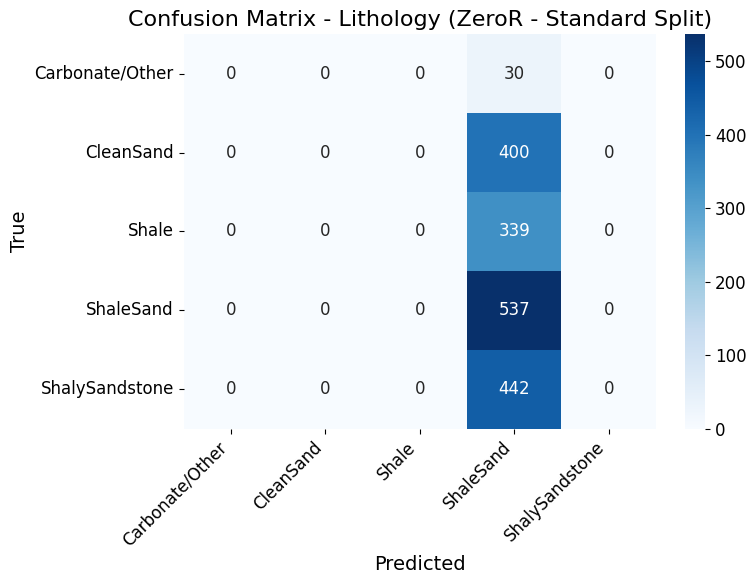


--- Training Random Forest Classifier (Y1)... ---

Random Forest Evaluation (Y1):
Accuracy: 0.7700
F1 Score (Macro): 0.7405
F1 Score (Weighted): 0.7689
Classification Report (RF Y1):
                  precision    recall  f1-score   support

Carbonate/Other       0.82      0.47      0.60        30
      CleanSand       0.82      0.90      0.86       400
          Shale       0.83      0.76      0.79       339
      ShaleSand       0.76      0.73      0.74       537
 ShalySandstone       0.69      0.74      0.71       442

       accuracy                           0.77      1748
      macro avg       0.79      0.72      0.74      1748
   weighted avg       0.77      0.77      0.77      1748



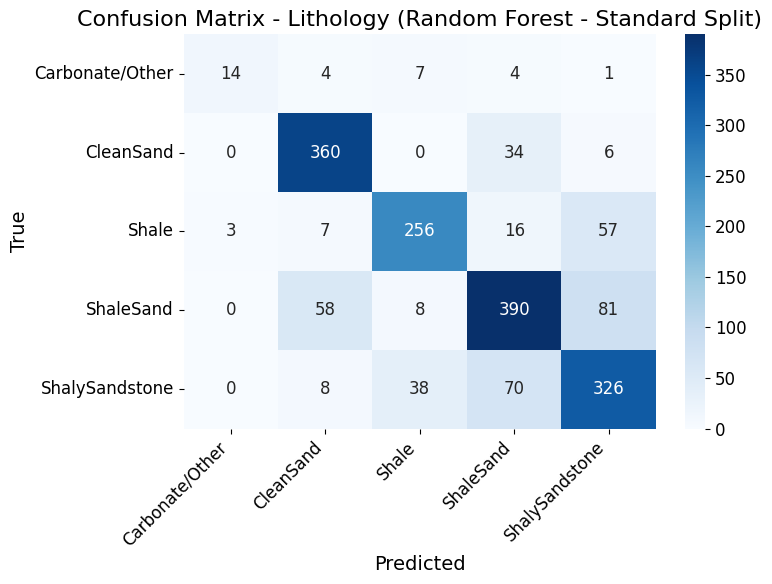


--- Training k-NN Classifier (Y1)... ---

k-NN Evaluation (Y1):
Accuracy: 0.6436
F1 Score (Macro): 0.6053
F1 Score (Weighted): 0.6403
Classification Report (k-NN Y1):
                  precision    recall  f1-score   support

Carbonate/Other       0.50      0.40      0.44        30
      CleanSand       0.70      0.80      0.75       400
          Shale       0.61      0.66      0.63       339
      ShaleSand       0.65      0.63      0.64       537
 ShalySandstone       0.60      0.52      0.56       442

       accuracy                           0.64      1748
      macro avg       0.61      0.60      0.61      1748
   weighted avg       0.64      0.64      0.64      1748



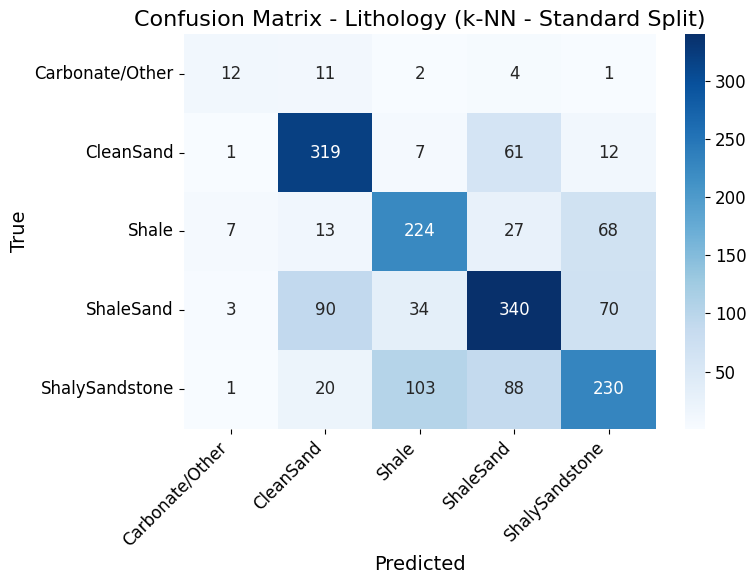

In [10]:
# Cell 8: --- Task 1 (Lithology) - Baseline Models (Standard Split) ---
if X_train_y1 is not None and y1_train is not None:
    print("\n=== Task 1: Lithology Classification (Standard Split) ===")
    y1_class_names = sorted(y1_train.unique())

    # --- ZeroR Classifier (Y1) ---
    print("\n--- Training ZeroR Classifier (Y1)... ---")
    zero_r_clf_y1 = DummyClassifier(strategy='most_frequent')
    zero_r_clf_y1.fit(X_train_y1, y1_train)
    y1_pred_zero = zero_r_clf_y1.predict(X_test_y1)

    print("\nZeroR Evaluation (Y1):")
    print(f"Accuracy: {accuracy_score(y1_test, y1_pred_zero):.4f}")
    print(f"F1 Score (Macro): {f1_score(y1_test, y1_pred_zero, average='macro', zero_division=0):.4f}")
    print(f"F1 Score (Weighted): {f1_score(y1_test, y1_pred_zero, average='weighted', zero_division=0):.4f}")
    print("Classification Report (ZeroR Y1):\n", classification_report(y1_test, y1_pred_zero, target_names=y1_class_names, zero_division=0))

    # Plotting ZeroR CM (Prof. Hsu's Feedback)
    cm_zero_y1 = confusion_matrix(y1_test, y1_pred_zero, labels=y1_class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_zero_y1, annot=True, fmt='d', cmap='Blues', xticklabels=y1_class_names, yticklabels=y1_class_names)
    plt.title('Confusion Matrix - Lithology (ZeroR - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=45, ha='right')
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Random Forest Classifier (Y1) ---
    print("\n--- Training Random Forest Classifier (Y1)... ---")
    rf_clf_y1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_clf_y1.fit(X_train_y1, y1_train)
    y1_pred_rf = rf_clf_y1.predict(X_test_y1)
    rf_accuracy_y1_hw6 = accuracy_score(y1_test, y1_pred_rf) # For later comparison
    rf_f1_macro_y1_hw6 = f1_score(y1_test, y1_pred_rf, average='macro', zero_division=0) # For later

    print("\nRandom Forest Evaluation (Y1):")
    print(f"Accuracy: {rf_accuracy_y1_hw6:.4f}")
    print(f"F1 Score (Macro): {rf_f1_macro_y1_hw6:.4f}")
    print(f"F1 Score (Weighted): {f1_score(y1_test, y1_pred_rf, average='weighted', zero_division=0):.4f}")
    print("Classification Report (RF Y1):\n", classification_report(y1_test, y1_pred_rf, target_names=y1_class_names, zero_division=0))

    cm_rf_y1 = confusion_matrix(y1_test, y1_pred_rf, labels=y1_class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf_y1, annot=True, fmt='d', cmap='Blues', xticklabels=y1_class_names, yticklabels=y1_class_names)
    plt.title('Confusion Matrix - Lithology (Random Forest - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=45, ha='right')
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=0)
    plt.tight_layout()
    plt.show()

    # --- k-NN Classifier (Y1) (Prof. Hsu's Feedback) ---
    print("\n--- Training k-NN Classifier (Y1)... ---")
    # k-NN benefits from feature scaling
    knn_pipeline_y1 = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    knn_pipeline_y1.fit(X_train_y1, y1_train)
    y1_pred_knn = knn_pipeline_y1.predict(X_test_y1)

    print("\nk-NN Evaluation (Y1):")
    print(f"Accuracy: {accuracy_score(y1_test, y1_pred_knn):.4f}")
    print(f"F1 Score (Macro): {f1_score(y1_test, y1_pred_knn, average='macro', zero_division=0):.4f}")
    print(f"F1 Score (Weighted): {f1_score(y1_test, y1_pred_knn, average='weighted', zero_division=0):.4f}")
    print("Classification Report (k-NN Y1):\n", classification_report(y1_test, y1_pred_knn, target_names=y1_class_names, zero_division=0))

    cm_knn_y1 = confusion_matrix(y1_test, y1_pred_knn, labels=y1_class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_knn_y1, annot=True, fmt='d', cmap='Blues', xticklabels=y1_class_names, yticklabels=y1_class_names)
    plt.title('Confusion Matrix - Lithology (k-NN - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=45, ha='right')
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping Task 1 Baseline Models: Data not available.")


=== Task 2: Fluid Type Classification (Standard Split) ===

--- Training ZeroR Classifier (Y2)... ---

ZeroR Evaluation (Y2):
Accuracy: 0.5069
F1 Score (Macro): 0.2242
F1 Score (Weighted): 0.3410
Classification Report (ZeroR Y2):
               precision    recall  f1-score   support

         Gas       0.00      0.00      0.00       421
         Oil       0.00      0.00      0.00       441
       Water       0.51      1.00      0.67       886

    accuracy                           0.51      1748
   macro avg       0.17      0.33      0.22      1748
weighted avg       0.26      0.51      0.34      1748



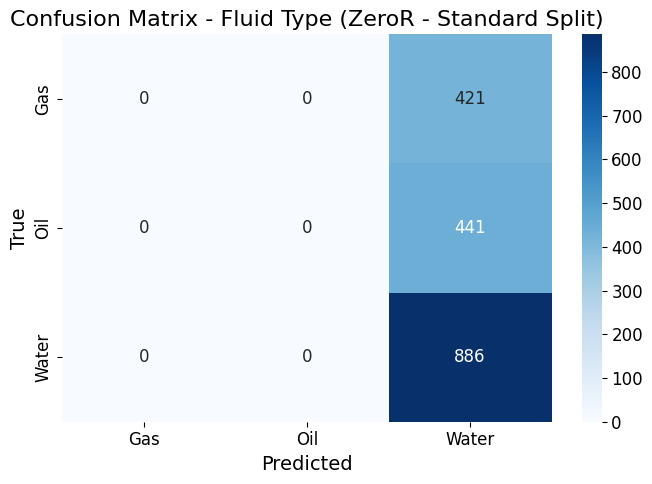


--- Training Random Forest Classifier (Y2)... ---

Random Forest Evaluation (Y2):
Accuracy: 0.9514
F1 Score (Macro): 0.9458
F1 Score (Weighted): 0.9514
Classification Report (RF Y2):
               precision    recall  f1-score   support

         Gas       0.97      0.96      0.96       421
         Oil       0.90      0.91      0.91       441
       Water       0.97      0.97      0.97       886

    accuracy                           0.95      1748
   macro avg       0.95      0.95      0.95      1748
weighted avg       0.95      0.95      0.95      1748



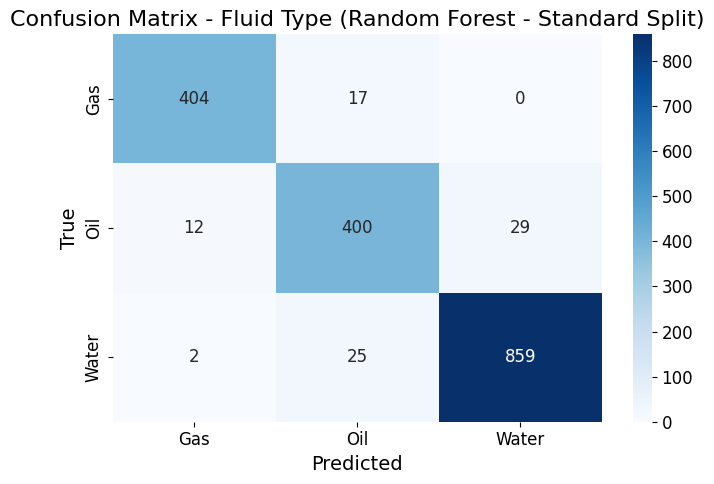


--- Training k-NN Classifier (Y2)... ---

k-NN Evaluation (Y2):
Accuracy: 0.8965
F1 Score (Macro): 0.8828
F1 Score (Weighted): 0.8955
Classification Report (k-NN Y2):
               precision    recall  f1-score   support

         Gas       0.92      0.91      0.92       421
         Oil       0.82      0.78      0.80       441
       Water       0.92      0.95      0.93       886

    accuracy                           0.90      1748
   macro avg       0.89      0.88      0.88      1748
weighted avg       0.90      0.90      0.90      1748



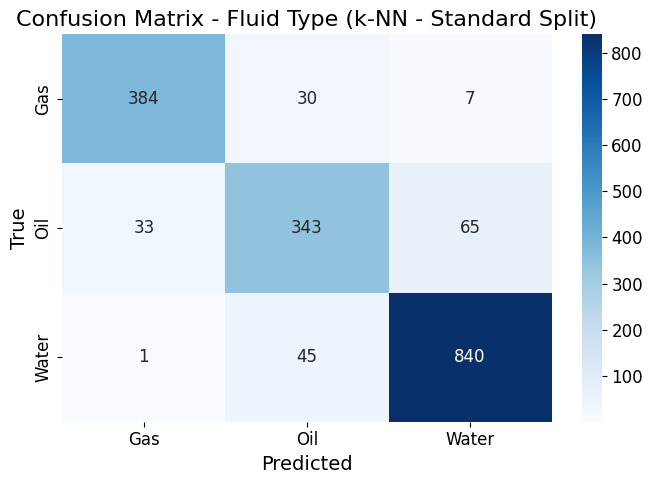

In [11]:
# Cell 9: --- Task 2 (Fluid Type) - Baseline Models (Standard Split) ---
if X_train_y2 is not None and y2_train is not None:
    print("\n=== Task 2: Fluid Type Classification (Standard Split) ===")
    y2_class_names = sorted(y2_train.unique())

    # --- ZeroR Classifier (Y2) ---
    print("\n--- Training ZeroR Classifier (Y2)... ---")
    zero_r_clf_y2 = DummyClassifier(strategy='most_frequent')
    zero_r_clf_y2.fit(X_train_y2, y2_train)
    y2_pred_zero = zero_r_clf_y2.predict(X_test_y2)

    print("\nZeroR Evaluation (Y2):")
    print(f"Accuracy: {accuracy_score(y2_test, y2_pred_zero):.4f}")
    print(f"F1 Score (Macro): {f1_score(y2_test, y2_pred_zero, average='macro', zero_division=0):.4f}")
    print(f"F1 Score (Weighted): {f1_score(y2_test, y2_pred_zero, average='weighted', zero_division=0):.4f}")
    print("Classification Report (ZeroR Y2):\n", classification_report(y2_test, y2_pred_zero, target_names=y2_class_names, zero_division=0))

    cm_zero_y2 = confusion_matrix(y2_test, y2_pred_zero, labels=y2_class_names)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_zero_y2, annot=True, fmt='d', cmap='Blues', xticklabels=y2_class_names, yticklabels=y2_class_names)
    plt.title('Confusion Matrix - Fluid Type (ZeroR - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.tight_layout()
    plt.show()

    # --- Random Forest Classifier (Y2) ---
    print("\n--- Training Random Forest Classifier (Y2)... ---")
    rf_clf_y2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_clf_y2.fit(X_train_y2, y2_train)
    y2_pred_rf = rf_clf_y2.predict(X_test_y2)
    rf_accuracy_y2_hw6 = accuracy_score(y2_test, y2_pred_rf) # For later
    rf_f1_macro_y2_hw6 = f1_score(y2_test, y2_pred_rf, average='macro', zero_division=0) # For later

    print("\nRandom Forest Evaluation (Y2):")
    print(f"Accuracy: {rf_accuracy_y2_hw6:.4f}")
    print(f"F1 Score (Macro): {rf_f1_macro_y2_hw6:.4f}")
    print(f"F1 Score (Weighted): {f1_score(y2_test, y2_pred_rf, average='weighted', zero_division=0):.4f}")
    print("Classification Report (RF Y2):\n", classification_report(y2_test, y2_pred_rf, target_names=y2_class_names, zero_division=0))

    cm_rf_y2 = confusion_matrix(y2_test, y2_pred_rf, labels=y2_class_names)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_rf_y2, annot=True, fmt='d', cmap='Blues', xticklabels=y2_class_names, yticklabels=y2_class_names)
    plt.title('Confusion Matrix - Fluid Type (Random Forest - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.tight_layout()
    plt.show()

    # --- k-NN Classifier (Y2) (Prof. Hsu's Feedback) ---
    print("\n--- Training k-NN Classifier (Y2)... ---")
    knn_pipeline_y2 = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    knn_pipeline_y2.fit(X_train_y2, y2_train)
    y2_pred_knn = knn_pipeline_y2.predict(X_test_y2)

    print("\nk-NN Evaluation (Y2):")
    print(f"Accuracy: {accuracy_score(y2_test, y2_pred_knn):.4f}")
    print(f"F1 Score (Macro): {f1_score(y2_test, y2_pred_knn, average='macro', zero_division=0):.4f}")
    print(f"F1 Score (Weighted): {f1_score(y2_test, y2_pred_knn, average='weighted', zero_division=0):.4f}")
    print("Classification Report (k-NN Y2):\n", classification_report(y2_test, y2_pred_knn, target_names=y2_class_names, zero_division=0))

    cm_knn_y2 = confusion_matrix(y2_test, y2_pred_knn, labels=y2_class_names)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_knn_y2, annot=True, fmt='d', cmap='Blues', xticklabels=y2_class_names, yticklabels=y2_class_names)
    plt.title('Confusion Matrix - Fluid Type (k-NN - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Task 2 Baseline Models: Data not available.")


=== Task 3: Porosity Regression (Standard Split) ===

--- Training ZeroR Regressor (Y3)... ---

ZeroR Evaluation (Y3):
MSE: 0.003692
RMSE: 0.060766
MAE: 0.009808
R2: -0.0003

--- Training Random Forest Regressor (Y3)... ---



Random Forest Evaluation (Y3):
MSE: 0.002946
RMSE: 0.054278
MAE: 0.007362
R2: 0.2019


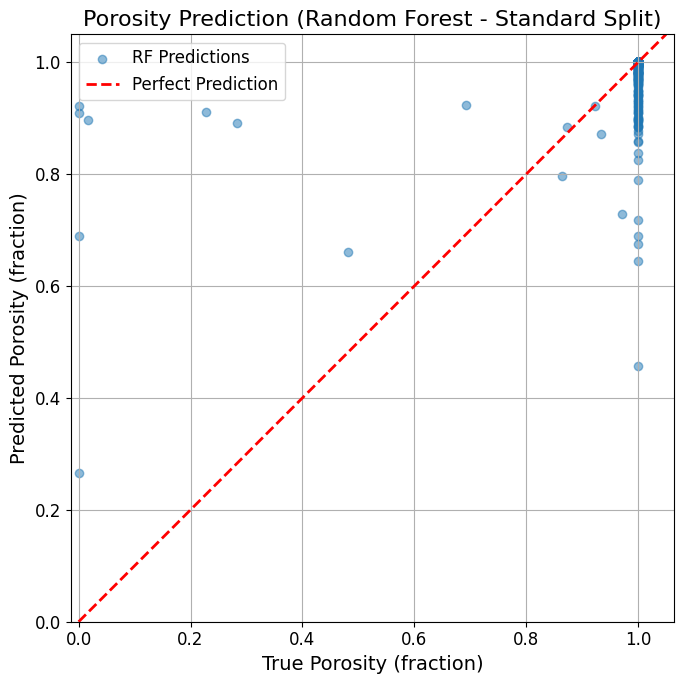

In [12]:
# Cell 10: --- Task 3 (Porosity) - Baseline Models (Standard Split) ---
if X_train_y3 is not None and y3_train is not None:
    print("\n=== Task 3: Porosity Regression (Standard Split) ===")

    # --- ZeroR Regressor (Y3) ---
    print("\n--- Training ZeroR Regressor (Y3)... ---")
    zero_r_reg_y3 = DummyRegressor(strategy='mean')
    zero_r_reg_y3.fit(X_train_y3, y3_train)
    y3_pred_zero = zero_r_reg_y3.predict(X_test_y3)

    print("\nZeroR Evaluation (Y3):")
    print(f"MSE: {mean_squared_error(y3_test, y3_pred_zero):.6f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y3_test, y3_pred_zero)):.6f}")
    print(f"MAE: {mean_absolute_error(y3_test, y3_pred_zero):.6f}")
    print(f"R2: {r2_score(y3_test, y3_pred_zero):.4f}")

    # --- Random Forest Regressor (Y3) ---
    print("\n--- Training Random Forest Regressor (Y3)... ---")
    rf_reg_y3 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_reg_y3.fit(X_train_y3, y3_train)
    y3_pred_rf = rf_reg_y3.predict(X_test_y3)
    rf_mse_y3_hw6 = mean_squared_error(y3_test, y3_pred_rf) # For later
    rf_rmse_y3_hw6 = np.sqrt(rf_mse_y3_hw6) # For later
    rf_mae_y3_hw6 = mean_absolute_error(y3_test, y3_pred_rf) # For later
    rf_r2_y3_hw6 = r2_score(y3_test, y3_pred_rf) # For later


    print("\nRandom Forest Evaluation (Y3):")
    print(f"MSE: {rf_mse_y3_hw6:.6f}")
    print(f"RMSE: {rf_rmse_y3_hw6:.6f}")
    print(f"MAE: {rf_mae_y3_hw6:.6f}")
    print(f"R2: {rf_r2_y3_hw6:.4f}")

    # Scatter Plot: True vs. Predicted Porosity (Random Forest)
    plt.figure(figsize=(7, 7))
    plt.scatter(y3_test, y3_pred_rf, alpha=0.5, label='RF Predictions')
    min_val_plot = min(y3_test.min(), y3_pred_rf.min()) * 0.95
    max_val_plot = max(y3_test.max(), y3_pred_rf.max()) * 1.05
    plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], '--r', linewidth=2, label='Perfect Prediction')
    plt.title('Porosity Prediction (Random Forest - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('True Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Predicted Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(min_val_plot, max_val_plot)
    plt.ylim(min_val_plot, max_val_plot)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Task 3 Baseline Models: Data not available.")


--- Training k-NN Regressor (Y3 - Porosity)... ---

k-NN Regressor Evaluation (Y3 - Porosity):
MSE: 0.003728
RMSE: 0.061061
MAE: 0.008093
R2: -0.0101


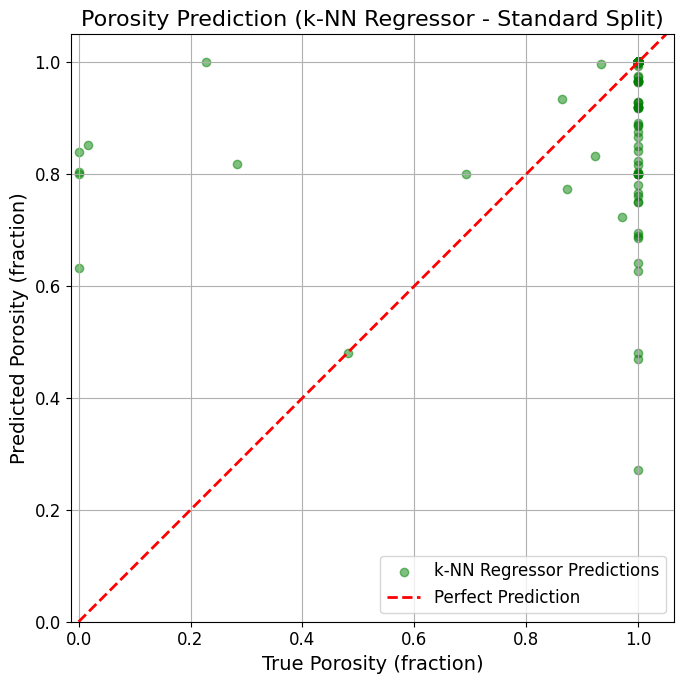

In [29]:

# --- k-NN Regressor (Y3 - Porosity) (Standard Split) ---
if X_train_y3 is not None and y3_train is not None: # Check if data is available
    print("\n--- Training k-NN Regressor (Y3 - Porosity)... ---")

    # k-NN benefits from feature scaling for regression as well
    # Creating a pipeline similar to the k-NN classifier
    from sklearn.neighbors import KNeighborsRegressor

    knn_reg_pipeline_y3 = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=5))
    ])

    # Train the k-NN Regressor
    knn_reg_pipeline_y3.fit(X_train_y3, y3_train)

    # Make predictions
    y3_pred_knn_reg = knn_reg_pipeline_y3.predict(X_test_y3)

    # Evaluate the k-NN Regressor
    knn_mse_y3 = mean_squared_error(y3_test, y3_pred_knn_reg)
    knn_rmse_y3 = np.sqrt(knn_mse_y3)
    knn_mae_y3 = mean_absolute_error(y3_test, y3_pred_knn_reg)
    knn_r2_y3 = r2_score(y3_test, y3_pred_knn_reg)

    print("\nk-NN Regressor Evaluation (Y3 - Porosity):")
    print(f"MSE: {knn_mse_y3:.6f}")
    print(f"RMSE: {knn_rmse_y3:.6f}")
    print(f"MAE: {knn_mae_y3:.6f}")
    print(f"R2: {knn_r2_y3:.4f}")

    # Scatter Plot: True vs. Predicted Porosity (k-NN Regressor)
    plt.figure(figsize=(7, 7))
    plt.scatter(y3_test, y3_pred_knn_reg, alpha=0.5, label='k-NN Regressor Predictions', color='green')
    min_val_plot_knn = min(y3_test.min(), y3_pred_knn_reg.min()) * 0.95
    max_val_plot_knn = max(y3_test.max(), y3_pred_knn_reg.max()) * 1.05
    plt.plot([min_val_plot_knn, max_val_plot_knn], [min_val_plot_knn, max_val_plot_knn], '--r', linewidth=2, label='Perfect Prediction')
    plt.title('Porosity Prediction (k-NN Regressor - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('True Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Predicted Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(min_val_plot_knn, max_val_plot_knn)
    plt.ylim(min_val_plot_knn, max_val_plot_knn)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping k-NN Regressor for Y3: Data not available.")


--- Scatter Plot for ZeroR Regressor (Y3 - Porosity)... ---


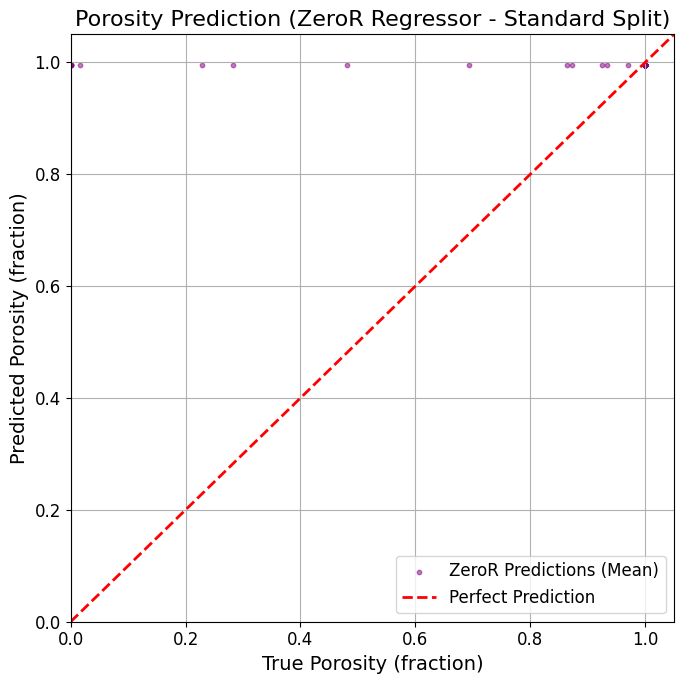

Note: All ZeroR predictions are the constant mean value: 0.9945


In [30]:


if 'y3_pred_zero' in globals() and 'y3_test' in globals():
    print("\n--- Scatter Plot for ZeroR Regressor (Y3 - Porosity)... ---")

    plt.figure(figsize=(7, 7))
    # Plot actual test values vs. the constant ZeroR predictions
    plt.scatter(y3_test, y3_pred_zero, alpha=0.5, label='ZeroR Predictions (Mean)', color='purple', s=10)

    # Add the Perfect Prediction line for reference
    min_val_plot_zero_r = min(y3_test.min(), y3_pred_zero.min()) * 0.95
    max_val_plot_zero_r = max(y3_test.max(), y3_pred_zero.max()) * 1.05
    # Adjust plot limits to ensure the horizontal line is clearly visible and data isn't too squashed
    plot_min_overall = min(min_val_plot_zero_r, y3_test.min())
    plot_max_overall = max(max_val_plot_zero_r, y3_test.max())


    plt.plot([plot_min_overall, plot_max_overall], [plot_min_overall, plot_max_overall],
             '--r', linewidth=2, label='Perfect Prediction')


    plt.title('Porosity Prediction (ZeroR Regressor - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('True Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Predicted Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True)

    # Set x and y limits to be the same for better comparison, accommodating true data range
    plt.xlim(plot_min_overall, plot_max_overall)
    plt.ylim(plot_min_overall, plot_max_overall)
    # plt.axis('equal')

    plt.tight_layout()
    plt.show()

    print(f"Note: All ZeroR predictions are the constant mean value: {y3_pred_zero[0]:.4f}")

else:
    print("Skipping ZeroR Regressor scatter plot for Y3: Data (y3_test or y3_pred_zero) not available.")

In [18]:
# Cell 11: Initial LSTM Setup: Scaling, Sequence Creation, Encoding (Standard Split) - CORRECTED

print("\n=== Initial LSTM Setup (Standard Split) ===")
window_size = 10
lstm_data_scaled = False

# Initialize scaled data and sequence variables
X_train_y1_scaled, X_test_y1_scaled = None, None
X_train_y2_scaled, X_test_y2_scaled = None, None
X_train_y3_scaled, X_test_y3_scaled = None, None

X_seq_train_y1, y_seq_train_y1, X_seq_test_y1, y_seq_test_y1 = [None]*4
y_seq_train_y1_encoded, y_seq_test_y1_encoded = None, None
encoder_y1_lstm = None
num_classes_y1_lstm = 0
y1_lstm_class_names = []

X_seq_train_y2, y_seq_train_y2, X_seq_test_y2, y_seq_test_y2 = [None]*4
y_seq_train_y2_encoded, y_seq_test_y2_encoded = None, None
encoder_y2_lstm = None
num_classes_y2_lstm = 0
y2_lstm_class_names = []

X_seq_train_y3, y_seq_train_y3, X_seq_test_y3, y_seq_test_y3 = [None]*4


if X_train_y1 is not None:
    print("\n--- Scaling Features for LSTMs (Standard Split) ---")
    scaler_y1_lstm = MinMaxScaler()
    X_train_y1_scaled = scaler_y1_lstm.fit_transform(X_train_y1)
    X_test_y1_scaled = scaler_y1_lstm.transform(X_test_y1)
    print(f"Shape of scaled X_train_y1: {X_train_y1_scaled.shape}")

    scaler_y2_lstm = MinMaxScaler()
    X_train_y2_scaled = scaler_y2_lstm.fit_transform(X_train_y2)
    X_test_y2_scaled = scaler_y2_lstm.transform(X_test_y2)
    print(f"Shape of scaled X_train_y2: {X_train_y2_scaled.shape}")

    scaler_y3_lstm = MinMaxScaler()
    X_train_y3_scaled = scaler_y3_lstm.fit_transform(X_train_y3)
    X_test_y3_scaled = scaler_y3_lstm.transform(X_test_y3)
    print(f"Shape of scaled X_train_y3: {X_train_y3_scaled.shape}")
    lstm_data_scaled = True

    # --- Prepare Sequential Data for Task 1 (Lithology LSTM) ---
    print("\n--- Preparing Sequential Data for Task 1 (LSTM - Standard Split) ---")
    if lstm_data_scaled and y1_train is not None:
        # y_train.values directly from pandas series is 1D, create_sequences keeps it 1D
        X_seq_train_y1, y_seq_train_y1 = create_sequences(X_train_y1_scaled, y1_train.values, window_size)
        X_seq_test_y1, y_seq_test_y1 = create_sequences(X_test_y1_scaled, y1_test.values, window_size)

        if X_seq_train_y1.size > 0 and X_seq_test_y1.size > 0 :
            print("One-hot encoding target Y1 for LSTM...")
            encoder_y1_lstm = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            #Reshape y_seq_train_y1 and y_seq_test_y1 to 2D for OneHotEncoder
            y_seq_train_y1_encoded = encoder_y1_lstm.fit_transform(y_seq_train_y1.reshape(-1, 1))
            y_seq_test_y1_encoded = encoder_y1_lstm.transform(y_seq_test_y1.reshape(-1, 1))
            num_classes_y1_lstm = y_seq_train_y1_encoded.shape[1]
            y1_lstm_class_names = encoder_y1_lstm.categories_[0].tolist()
            print(f"Shape of one-hot y_seq_train_y1: {y_seq_train_y1_encoded.shape}")
            print(f"Number of classes for Y1 (LSTM): {num_classes_y1_lstm}, Names: {y1_lstm_class_names}")
        else: print("Skipping Y1 LSTM One-Hot Encoding: Sequence creation failed.")
    else: print("Skipping Task 1 LSTM data prep: Scaled data or target not available.")

    # --- Prepare Sequential Data for Task 2 (Fluid Type LSTM) ---
    print("\n--- Preparing Sequential Data for Task 2 (LSTM - Standard Split) ---")
    if lstm_data_scaled and y2_train is not None:
        X_seq_train_y2, y_seq_train_y2 = create_sequences(X_train_y2_scaled, y2_train.values, window_size)
        X_seq_test_y2, y_seq_test_y2 = create_sequences(X_test_y2_scaled, y2_test.values, window_size)

        if X_seq_train_y2.size > 0 and X_seq_test_y2.size > 0 :
            print("One-hot encoding target Y2 for LSTM...")
            encoder_y2_lstm = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            #Reshape y_seq_train_y2 and y_seq_test_y2 to 2D for OneHotEncoder
            y_seq_train_y2_encoded = encoder_y2_lstm.fit_transform(y_seq_train_y2.reshape(-1, 1))
            y_seq_test_y2_encoded = encoder_y2_lstm.transform(y_seq_test_y2.reshape(-1, 1))
            num_classes_y2_lstm = y_seq_train_y2_encoded.shape[1]
            y2_lstm_class_names = encoder_y2_lstm.categories_[0].tolist()
            print(f"Shape of one-hot y_seq_train_y2: {y_seq_train_y2_encoded.shape}")
            print(f"Number of classes for Y2 (LSTM): {num_classes_y2_lstm}, Names: {y2_lstm_class_names}")
        else: print("Skipping Y2 LSTM One-Hot Encoding: Sequence creation failed.")
    else: print("Skipping Task 2 LSTM data prep: Scaled data or target not available.")

    # --- Prepare Sequential Data for Task 3 (Porosity LSTM) ---
    print("\n--- Preparing Sequential Data for Task 3 (LSTM - Standard Split) ---")
    if lstm_data_scaled and y3_train is not None:
        # y_train (porosity) is already numeric (1D), no one-hot encoding needed
        X_seq_train_y3, y_seq_train_y3 = create_sequences(X_train_y3_scaled, y3_train.values, window_size)
        X_seq_test_y3, y_seq_test_y3 = create_sequences(X_test_y3_scaled, y3_test.values, window_size)
        if not (X_seq_train_y3.size > 0 and X_seq_test_y3.size > 0):
             print("Skipping Y3 LSTM Sequence Data: Sequence creation failed.")
        else:
            print(f"Created Y3 LSTM sequences: X_train shape {X_seq_train_y3.shape}, y_train shape {y_seq_train_y3.shape}")
    else: print("Skipping Task 3 LSTM data prep: Scaled data or target not available.")

else:
    print("Skipping LSTM setup: Initial data split not available.")


=== Initial LSTM Setup (Standard Split) ===

--- Scaling Features for LSTMs (Standard Split) ---
Shape of scaled X_train_y1: (6991, 11)
Shape of scaled X_train_y2: (6991, 11)
Shape of scaled X_train_y3: (6991, 10)

--- Preparing Sequential Data for Task 1 (LSTM - Standard Split) ---
Creating sequences with window size 10 from data shape (6991, 11)...
Created sequences: X shape (6981, 10, 11), y shape (6981,)
Creating sequences with window size 10 from data shape (1748, 11)...
Created sequences: X shape (1738, 10, 11), y shape (1738,)
One-hot encoding target Y1 for LSTM...
Shape of one-hot y_seq_train_y1: (6981, 5)
Number of classes for Y1 (LSTM): 5, Names: ['Carbonate/Other', 'CleanSand', 'Shale', 'ShaleSand', 'ShalySandstone']

--- Preparing Sequential Data for Task 2 (LSTM - Standard Split) ---
Creating sequences with window size 10 from data shape (6991, 11)...
Created sequences: X shape (6981, 10, 11), y shape (6981,)
Creating sequences with window size 10 from data shape (1748, 1

In [19]:
# Cell 12: Initial LSTM Model Definition
def build_initial_lstm_classifier(input_shape, num_classes):
    model = Sequential(name=f"Initial_LSTM_Classifier_{num_classes}Classes")
    model.add(Input(shape=input_shape, name='Input_Sequence'))
    model.add(KerasLSTM(units=50, return_sequences=True, name='LSTM_1'))
    model.add(Dropout(0.2, name='Dropout_1'))
    model.add(KerasLSTM(units=50, return_sequences=False, name='LSTM_2'))
    model.add(Dropout(0.2, name='Dropout_2'))
    model.add(Dense(units=32, activation='relu', name='Dense_Hidden'))
    model.add(Dense(units=num_classes, activation='softmax', name='Output_Softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Built Initial LSTM Classifier with input shape {input_shape} and {num_classes} output classes.")
    return model

def build_initial_lstm_regressor(input_shape):
    model = Sequential(name="Initial_LSTM_Regressor")
    model.add(Input(shape=input_shape, name='Input_Sequence'))
    model.add(KerasLSTM(units=50, return_sequences=True, name='LSTM_1'))
    model.add(Dropout(0.2, name='Dropout_1'))
    model.add(KerasLSTM(units=50, return_sequences=False, name='LSTM_2'))
    model.add(Dropout(0.2, name='Dropout_2'))
    model.add(Dense(units=32, activation='relu', name='Dense_Hidden'))
    model.add(Dense(units=1, activation='linear', name='Output_Linear')) # Linear for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    print(f"Built Initial LSTM Regressor with input shape {input_shape}.")
    return model

print("Initial LSTM model builder functions defined.")

Initial LSTM model builder functions defined.



=== Training Initial LSTM Classifier (Y1 - Lithology - Standard Split) ===
Built Initial LSTM Classifier with input shape (10, 11) and 5 output classes.

Initial LSTM Y1 Model Summary:


Model: "Initial_LSTM_Classifier_5Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 10, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Softmax (Dense)          │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,397 (134.36 KB)

 Trainable params: 34,397 (134.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.2934 - loss: 1.4940 - val_accuracy: 0.3228 - val_loss: 1.4417
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2887 - loss: 1.4378 - val_accuracy: 0.3228 - val_loss: 1.4409
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2720 - loss: 1.4467 - val_accuracy: 0.3228 - val_loss: 1.4454
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3040 - loss: 1.4354 - val_accuracy: 0.3228 - val_loss: 1.4453
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3075 - loss: 1.4352 - val_accuracy: 0.3228 - val_loss: 1.4434
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2922 - loss: 1.4369 - val_accuracy: 0.3228 - val_loss: 1.4438
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2999 - loss: 1.4356 - val_accuracy: 0.3228 - val_loss: 1.4420
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3021 - loss: 1.4320 - val_accuracy: 0.3228 - 

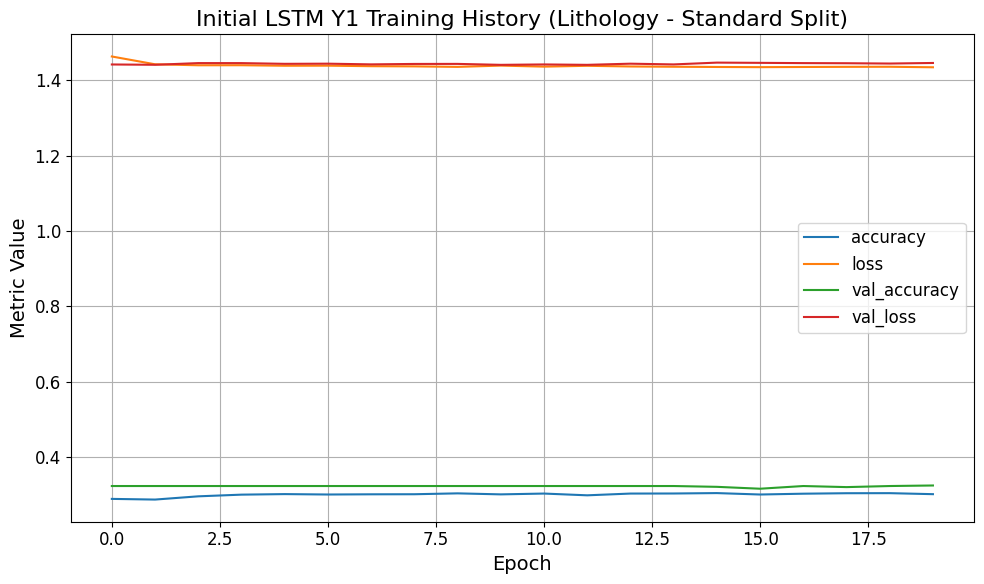


Evaluating Initial LSTM Y1 on Test Sequences (Standard Split)...
Initial LSTM Y1 Test Loss: 1.4366
Initial LSTM Y1 Test Accuracy: 0.3055
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Initial LSTM Y1 F1 Score (Macro): 0.0936
Initial LSTM Y1 F1 Score (Weighted): 0.1430
Classification Report (Initial LSTM Y1 - Standard Split):
                  precision    recall  f1-score   support

Carbonate/Other       0.00      0.00      0.00        30
      CleanSand       0.00      0.00      0.00       398
          Shale       0.00      0.00      0.00       338
      ShaleSand       0.31      1.00      0.47       531
 ShalySandstone       0.00      0.00      0.00       441

       accuracy                           0.31      1738
      macro avg       0.06      0.20      0.09      1738
   weighted avg       0.09      0.31      0.14      1738


Comparison with ZeroR (Y1 - Standard Split):
  ZeroR Accuracy: 0.3061 vs LSTM Accuracy: 0.3055
  ZeroR F1 Macro: 0.0937 vs LSTM F1 Macro: 0.0936
  Note: Initial 

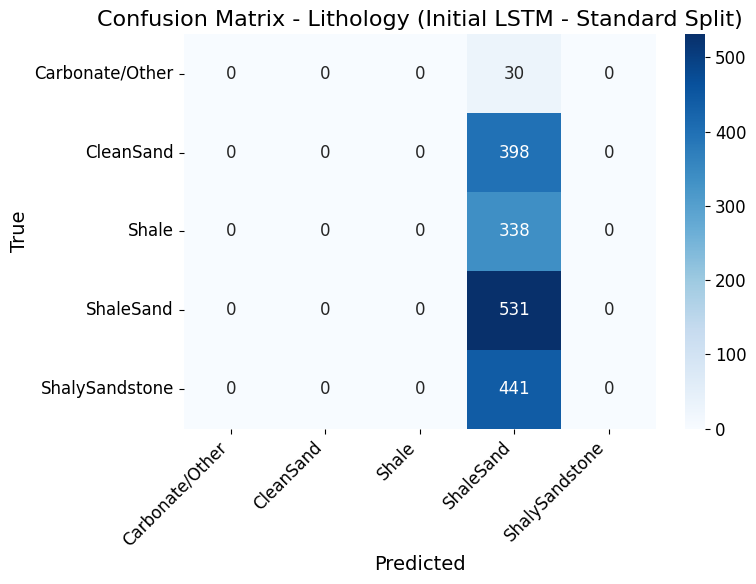

In [20]:
# Cell 13: --- Initial LSTM Model Training & Evaluation: Task 1 (Lithology - Standard Split) ---

lstm_model_y1 = None
history_y1 = None

if X_seq_train_y1 is not None and y_seq_train_y1_encoded is not None and num_classes_y1_lstm > 0:
    print("\n=== Training Initial LSTM Classifier (Y1 - Lithology - Standard Split) ===")
    input_shape_y1 = (X_seq_train_y1.shape[1], X_seq_train_y1.shape[2])
    lstm_model_y1 = build_initial_lstm_classifier(input_shape_y1, num_classes_y1_lstm)
    print("\nInitial LSTM Y1 Model Summary:")
    lstm_model_y1.summary()

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    t_start_lstm_y1 = time.time()
    history_y1 = lstm_model_y1.fit(
        X_seq_train_y1, y_seq_train_y1_encoded,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping_cb],
        verbose=1
    )
    t_end_lstm_y1 = time.time()
    print(f"\nInitial LSTM Y1 Training Time: {t_end_lstm_y1 - t_start_lstm_y1:.2f} seconds (Epochs run: {len(history_y1.epoch)})")

    # Plot training history
    pd.DataFrame(history_y1.history).plot(figsize=(10, 6))
    plt.title("Initial LSTM Y1 Training History (Lithology - Standard Split)", fontsize=TITLE_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel("Metric Value", fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate on test sequences
    print("\nEvaluating Initial LSTM Y1 on Test Sequences (Standard Split)...")
    loss_y1_lstm, accuracy_y1_lstm = lstm_model_y1.evaluate(X_seq_test_y1, y_seq_test_y1_encoded, verbose=0)
    print(f"Initial LSTM Y1 Test Loss: {loss_y1_lstm:.4f}")
    print(f"Initial LSTM Y1 Test Accuracy: {accuracy_y1_lstm:.4f}")

    y1_pred_prob_lstm = lstm_model_y1.predict(X_seq_test_y1)
    y1_pred_lstm_labels = encoder_y1_lstm.inverse_transform(y1_pred_prob_lstm).ravel()
    y_seq_test_y1_labels = y_seq_test_y1.ravel()

    f1_macro_y1_lstm_val = f1_score(y_seq_test_y1_labels, y1_pred_lstm_labels, average='macro', zero_division=0)
    f1_weighted_y1_lstm_val = f1_score(y_seq_test_y1_labels, y1_pred_lstm_labels, average='weighted', zero_division=0)
    print(f"Initial LSTM Y1 F1 Score (Macro): {f1_macro_y1_lstm_val:.4f}")
    print(f"Initial LSTM Y1 F1 Score (Weighted): {f1_weighted_y1_lstm_val:.4f}")
    print("Classification Report (Initial LSTM Y1 - Standard Split):\n",
          classification_report(y_seq_test_y1_labels, y1_pred_lstm_labels, target_names=y1_lstm_class_names, zero_division=0))

    # Compare with ZeroR (Prof. Hsu's Feedback)
    if 'y1_pred_zero' in globals():
        zero_r_accuracy_y1 = accuracy_score(y1_test[:len(y_seq_test_y1_labels)], y1_pred_zero[:len(y_seq_test_y1_labels)])
        zero_r_f1_macro_y1 = f1_score(y1_test[:len(y_seq_test_y1_labels)], y1_pred_zero[:len(y_seq_test_y1_labels)], average='macro', zero_division=0)
        print(f"\nComparison with ZeroR (Y1 - Standard Split):")
        print(f"  ZeroR Accuracy: {zero_r_accuracy_y1:.4f} vs LSTM Accuracy: {accuracy_y1_lstm:.4f}")
        print(f"  ZeroR F1 Macro: {zero_r_f1_macro_y1:.4f} vs LSTM F1 Macro: {f1_macro_y1_lstm_val:.4f}")
        if accuracy_y1_lstm < zero_r_accuracy_y1:
            print("  Note: Initial LSTM Y1 Accuracy is LESS than ZeroR Accuracy.")
        if f1_macro_y1_lstm_val < zero_r_f1_macro_y1:
            print("  Note: Initial LSTM Y1 F1 Macro is LESS than ZeroR F1 Macro.")


    cm_lstm_y1 = confusion_matrix(y_seq_test_y1_labels, y1_pred_lstm_labels, labels=y1_lstm_class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lstm_y1, annot=True, fmt='d', cmap='Blues', xticklabels=y1_lstm_class_names, yticklabels=y1_lstm_class_names)
    plt.title('Confusion Matrix - Lithology (Initial LSTM - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=45, ha='right')
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE, rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Initial LSTM Y1 training: Prerequisite data not available.")


=== Training Initial LSTM Classifier (Y2 - Fluid Type - Standard Split) ===
Built Initial LSTM Classifier with input shape (10, 11) and 3 output classes.

Initial LSTM Y2 Model Summary:


Model: "Initial_LSTM_Classifier_3Classes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 10, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Softmax (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,331 (134.11 KB)

 Trainable params: 34,331 (134.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5016 - loss: 1.0478 - val_accuracy: 0.5004 - val_loss: 1.0406
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5082 - loss: 1.0355 - val_accuracy: 0.5004 - val_loss: 1.0392
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5125 - loss: 1.0335 - val_accuracy: 0.5004 - val_loss: 1.0390
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4986 - loss: 1.0416 - val_accuracy: 0.5004 - val_loss: 1.0407
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5012 - loss: 1.0428 - val_accuracy: 0.5004 - val_loss: 1.0397
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5041 - loss: 1.0405 - val_accuracy: 0.5004 - val_loss: 1.0386
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5039 - loss: 1.0368 - val_accuracy: 0.5004 - val_loss: 1.0396
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5140 - loss: 1.0318 - val_accuracy: 0.5004 - 

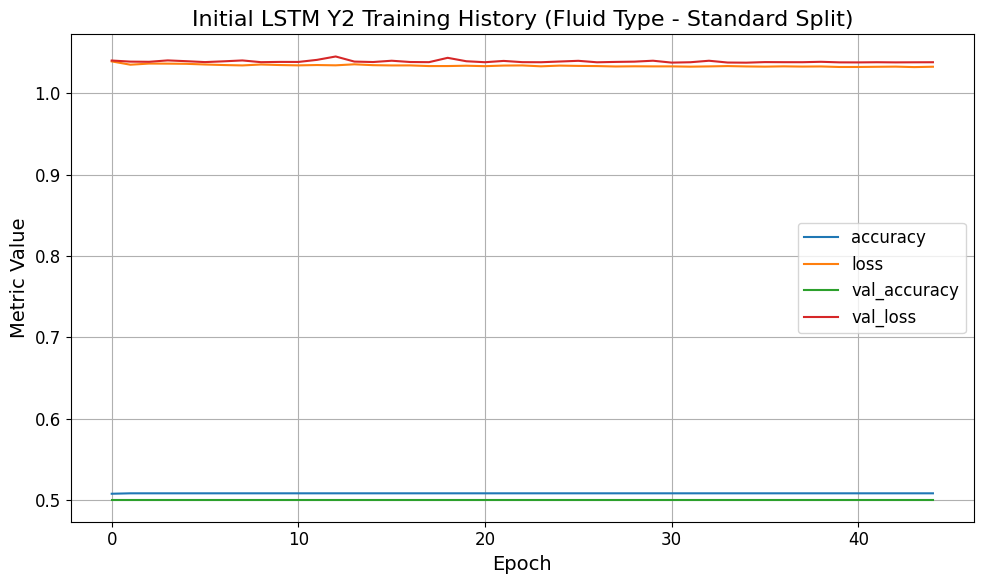


Evaluating Initial LSTM Y2 on Test Sequences (Standard Split)...
Initial LSTM Y2 Test Loss: 1.0371
Initial LSTM Y2 Test Accuracy: 0.5069
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Initial LSTM Y2 F1 Score (Macro): 0.2243
Initial LSTM Y2 F1 Score (Weighted): 0.3410
Classification Report (Initial LSTM Y2 - Standard Split):
               precision    recall  f1-score   support

         Gas       0.00      0.00      0.00       420
         Oil       0.00      0.00      0.00       437
       Water       0.51      1.00      0.67       881

    accuracy                           0.51      1738
   macro avg       0.17      0.33      0.22      1738
weighted avg       0.26      0.51      0.34      1738


Comparison with ZeroR (Y2 - Standard Split):
  ZeroR Accuracy: 0.5063 vs LSTM Accuracy: 0.5069
  ZeroR F1 Macro: 0.2241 vs LSTM F1 Macro: 0.2243


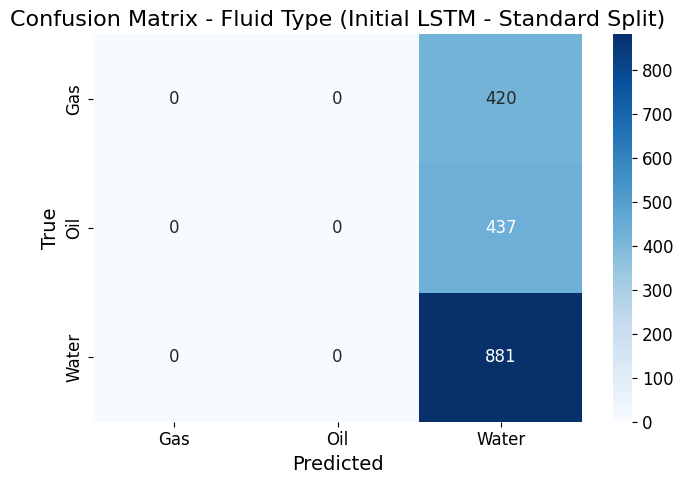

In [21]:
# Cell 14: --- Initial LSTM Model Training & Evaluation: Task 2 (Fluid Type - Standard Split) ---
lstm_model_y2 = None
history_y2 = None

if X_seq_train_y2 is not None and y_seq_train_y2_encoded is not None and num_classes_y2_lstm > 0:
    print("\n=== Training Initial LSTM Classifier (Y2 - Fluid Type - Standard Split) ===")
    input_shape_y2 = (X_seq_train_y2.shape[1], X_seq_train_y2.shape[2])
    lstm_model_y2 = build_initial_lstm_classifier(input_shape_y2, num_classes_y2_lstm)
    print("\nInitial LSTM Y2 Model Summary:")
    lstm_model_y2.summary()

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    t_start_lstm_y2 = time.time()
    history_y2 = lstm_model_y2.fit(
        X_seq_train_y2, y_seq_train_y2_encoded,
        epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping_cb], verbose=1
    )
    t_end_lstm_y2 = time.time()
    print(f"\nInitial LSTM Y2 Training Time: {t_end_lstm_y2 - t_start_lstm_y2:.2f} seconds (Epochs run: {len(history_y2.epoch)})")

    pd.DataFrame(history_y2.history).plot(figsize=(10, 6))
    plt.title("Initial LSTM Y2 Training History (Fluid Type - Standard Split)", fontsize=TITLE_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=AXIS_LABEL_FONT_SIZE); plt.ylabel("Metric Value", fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE); plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE); plt.grid(True); plt.tight_layout(); plt.show()

    print("\nEvaluating Initial LSTM Y2 on Test Sequences (Standard Split)...")
    loss_y2_lstm, accuracy_y2_lstm = lstm_model_y2.evaluate(X_seq_test_y2, y_seq_test_y2_encoded, verbose=0)
    print(f"Initial LSTM Y2 Test Loss: {loss_y2_lstm:.4f}")
    print(f"Initial LSTM Y2 Test Accuracy: {accuracy_y2_lstm:.4f}")

    y2_pred_prob_lstm = lstm_model_y2.predict(X_seq_test_y2)
    y2_pred_lstm_labels = encoder_y2_lstm.inverse_transform(y2_pred_prob_lstm).ravel()
    y_seq_test_y2_labels = y_seq_test_y2.ravel()

    f1_macro_y2_lstm_val = f1_score(y_seq_test_y2_labels, y2_pred_lstm_labels, average='macro', zero_division=0)
    f1_weighted_y2_lstm_val = f1_score(y_seq_test_y2_labels, y2_pred_lstm_labels, average='weighted', zero_division=0)
    print(f"Initial LSTM Y2 F1 Score (Macro): {f1_macro_y2_lstm_val:.4f}")
    print(f"Initial LSTM Y2 F1 Score (Weighted): {f1_weighted_y2_lstm_val:.4f}")
    print("Classification Report (Initial LSTM Y2 - Standard Split):\n",
          classification_report(y_seq_test_y2_labels, y2_pred_lstm_labels, target_names=y2_lstm_class_names, zero_division=0))

    # Compare with ZeroR
    if 'y2_pred_zero' in globals():
        zero_r_accuracy_y2 = accuracy_score(y2_test[:len(y_seq_test_y2_labels)], y2_pred_zero[:len(y_seq_test_y2_labels)])
        zero_r_f1_macro_y2 = f1_score(y2_test[:len(y_seq_test_y2_labels)], y2_pred_zero[:len(y_seq_test_y2_labels)], average='macro', zero_division=0)
        print(f"\nComparison with ZeroR (Y2 - Standard Split):")
        print(f"  ZeroR Accuracy: {zero_r_accuracy_y2:.4f} vs LSTM Accuracy: {accuracy_y2_lstm:.4f}")
        print(f"  ZeroR F1 Macro: {zero_r_f1_macro_y2:.4f} vs LSTM F1 Macro: {f1_macro_y2_lstm_val:.4f}")
        if accuracy_y2_lstm < zero_r_accuracy_y2: print("  Note: Initial LSTM Y2 Accuracy is LESS than ZeroR Accuracy.")
        if f1_macro_y2_lstm_val < zero_r_f1_macro_y2: print("  Note: Initial LSTM Y2 F1 Macro is LESS than ZeroR F1 Macro.")


    cm_lstm_y2 = confusion_matrix(y_seq_test_y2_labels, y2_pred_lstm_labels, labels=y2_lstm_class_names)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_lstm_y2, annot=True, fmt='d', cmap='Blues', xticklabels=y2_lstm_class_names, yticklabels=y2_lstm_class_names)
    plt.title('Confusion Matrix - Fluid Type (Initial LSTM - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Predicted', fontsize=AXIS_LABEL_FONT_SIZE); plt.ylabel('True', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE); plt.yticks(fontsize=TICK_LABEL_FONT_SIZE); plt.tight_layout(); plt.show()
else:
    print("Skipping Initial LSTM Y2 training: Prerequisite data not available.")


=== Training Initial LSTM Regressor (Y3 - Porosity - Standard Split) ===
Built Initial LSTM Regressor with input shape (10, 10).

Initial LSTM Y3 Model Summary:


Model: "Initial_LSTM_Regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 10, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Linear (Dense)           │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,065 (133.07 KB)

 Trainable params: 34,065 (133.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.2121 - mae: 0.3392 - val_loss: 0.0041 - val_mae: 0.0287
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0118 - mae: 0.0772 - val_loss: 0.0038 - val_mae: 0.0241
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0111 - mae: 0.0659 - val_loss: 0.0041 - val_mae: 0.0339
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0086 - mae: 0.0582 - val_loss: 0.0048 - val_mae: 0.0452
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0080 - mae: 0.0529 - val_loss: 0.0042 - val_mae: 0.0364
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0074 - mae: 0.0479 - val_loss: 0.0039 - val_mae: 0.0320
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0069 - mae: 0.0450 - val_loss: 0.0038 - val_mae: 0.0298
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0051 - mae: 0.0398 - val_loss: 0.0044 - val_mae: 0.0415
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.00

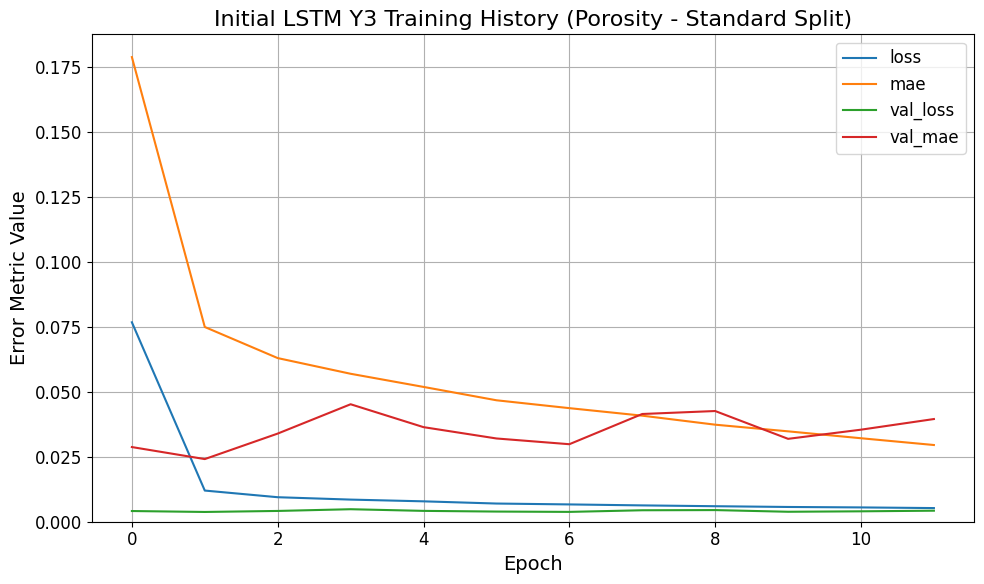


Evaluating Initial LSTM Y3 on Test Sequences (Standard Split)...
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Initial LSTM Y3 Test MSE: 0.004235
Initial LSTM Y3 Test RMSE: 0.065075
Initial LSTM Y3 Test MAE: 0.025240
Initial LSTM Y3 Test R2: -0.1407


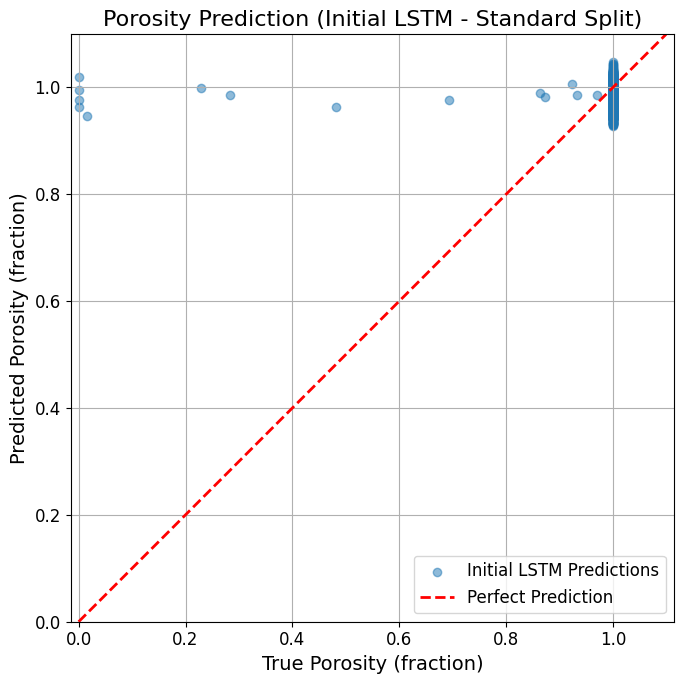

In [22]:
# Cell 15: --- Initial LSTM Model Training & Evaluation: Task 3 (Porosity - Standard Split) ---
lstm_model_y3 = None
history_y3 = None

if X_seq_train_y3 is not None and y_seq_train_y3 is not None:
    print("\n=== Training Initial LSTM Regressor (Y3 - Porosity - Standard Split) ===")
    input_shape_y3 = (X_seq_train_y3.shape[1], X_seq_train_y3.shape[2])
    lstm_model_y3 = build_initial_lstm_regressor(input_shape_y3)
    print("\nInitial LSTM Y3 Model Summary:")
    lstm_model_y3.summary()

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    t_start_lstm_y3 = time.time()
    history_y3 = lstm_model_y3.fit(
        X_seq_train_y3, y_seq_train_y3,
        epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping_cb], verbose=1
    )
    t_end_lstm_y3 = time.time()
    print(f"\nInitial LSTM Y3 Training Time: {t_end_lstm_y3 - t_start_lstm_y3:.2f} seconds (Epochs run: {len(history_y3.epoch)})")

    pd.DataFrame(history_y3.history).plot(figsize=(10, 6))
    plt.title("Initial LSTM Y3 Training History (Porosity - Standard Split)", fontsize=TITLE_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=AXIS_LABEL_FONT_SIZE); plt.ylabel("Error Metric Value", fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE); plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE); plt.grid(True); plt.ylim(bottom=0); plt.tight_layout(); plt.show()

    print("\nEvaluating Initial LSTM Y3 on Test Sequences (Standard Split)...")
    loss_y3_lstm_mse, mae_y3_lstm = lstm_model_y3.evaluate(X_seq_test_y3, y_seq_test_y3, verbose=0)
    y3_pred_lstm = lstm_model_y3.predict(X_seq_test_y3).flatten()
    rmse_y3_lstm_val = np.sqrt(loss_y3_lstm_mse)
    r2_y3_lstm_val = r2_score(y_seq_test_y3, y3_pred_lstm)

    print(f"Initial LSTM Y3 Test MSE: {loss_y3_lstm_mse:.6f}")
    print(f"Initial LSTM Y3 Test RMSE: {rmse_y3_lstm_val:.6f}")
    print(f"Initial LSTM Y3 Test MAE: {mae_y3_lstm:.6f}")
    print(f"Initial LSTM Y3 Test R2: {r2_y3_lstm_val:.4f}")

    plt.figure(figsize=(7, 7))
    plt.scatter(y_seq_test_y3, y3_pred_lstm, alpha=0.5, label='Initial LSTM Predictions')
    min_val_plot = min(y_seq_test_y3.min(), y3_pred_lstm.min()) * 0.95
    max_val_plot = max(y_seq_test_y3.max(), y3_pred_lstm.max()) * 1.05
    plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], '--r', linewidth=2, label='Perfect Prediction')
    plt.title('Porosity Prediction (Initial LSTM - Standard Split)', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('True Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Predicted Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE); plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE); plt.grid(True); plt.axis('equal')
    plt.xlim(min_val_plot, max_val_plot); plt.ylim(min_val_plot, max_val_plot); plt.tight_layout(); plt.show()
else:
    print("Skipping Initial LSTM Y3 training: Prerequisite data not available.")

In [23]:
# Cell 16: --- Extrapolation Analysis Setup: Chronological Split ---
print("\n=== Extrapolation Analysis Setup: Chronological Data Splitting & Re-Scaling ===")
extrapolation_data_available = False
df_train_val, df_extrap = None, None

# Variables for chronological data
X_y1_train_val, X_y1_extrap, Y1_train_val, Y1_extrap = [None]*4
X_y2_train_val, X_y2_extrap, Y2_train_val, Y2_extrap = [None]*4
X_y3_train_val, X_y3_extrap, Y3_train_val, Y3_extrap = [None]*4

# Scaled features for extrapolation LSTM
X_y1_train_val_scaled_ext, X_y1_extrap_scaled_ext = None, None
X_y2_train_val_scaled_ext, X_y2_extrap_scaled_ext = None, None
X_y3_train_val_scaled_ext, X_y3_extrap_scaled_ext = None, None


if df_processed is not None and not df_processed.empty:
    split_fraction = 0.80
    split_index = int(len(df_processed) * split_fraction)

    df_train_val = df_processed.iloc[:split_index].copy()
    df_extrap = df_processed.iloc[split_index:].copy()

    print(f"Full processed data shape: {df_processed.shape}")
    print(f"Training/Validation data shape (chronological): {df_train_val.shape}")
    print(f"Extrapolation test data shape (chronological): {df_extrap.shape}")

    if df_train_val.empty or df_extrap.empty:
        print("Warning: Chronological split resulted in empty DataFrames. Check split fraction or data size.")
    else:
        print("\n--- Preparing Task-Specific Features for New Chronological Splits ---")
        # Extract Targets for the new splits
        Y1_train_val = df_train_val['Y1_Lithology']
        Y1_extrap = df_extrap['Y1_Lithology']
        Y2_train_val = df_train_val['Y2_FluidType']
        Y2_extrap = df_extrap['Y2_FluidType']
        Y3_train_val = df_train_val['Y3_Porosity']
        Y3_extrap = df_extrap['Y3_Porosity']

        # Re-use feature dropping logic (base_features_to_drop and original_string_targets_to_drop from Cell 7)
        derived_targets = ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']

        # Y1 Chronological
        features_to_drop_y1_ext = list(base_features_to_drop) + list(original_string_targets_to_drop)
        if 'GR' in df_train_val.columns: features_to_drop_y1_ext.append('GR')
        X_y1_train_val = prepare_features_targets_specific(df_train_val, derived_targets, features_to_drop_y1_ext)
        X_y1_extrap = prepare_features_targets_specific(df_extrap, derived_targets, features_to_drop_y1_ext)
        print(f"Y1 Chrono Features: Train {X_y1_train_val.shape}, Extrap {X_y1_extrap.shape}")
        print(f"Features for Y1 (Chrono): {X_y1_train_val.columns.tolist()}")


        # Y2 Chronological
        features_to_drop_y2_ext = list(base_features_to_drop) + list(original_string_targets_to_drop)
        if 'RILD' in df_train_val.columns: features_to_drop_y2_ext.append('RILD')
        X_y2_train_val = prepare_features_targets_specific(df_train_val, derived_targets, features_to_drop_y2_ext)
        X_y2_extrap = prepare_features_targets_specific(df_extrap, derived_targets, features_to_drop_y2_ext)
        print(f"Y2 Chrono Features: Train {X_y2_train_val.shape}, Extrap {X_y2_extrap.shape}")
        print(f"Features for Y2 (Chrono): {X_y2_train_val.columns.tolist()}")


        # Y3 Chronological
        features_to_drop_y3_ext = list(base_features_to_drop) + list(original_string_targets_to_drop)
        if 'DPOR' in df_train_val.columns: features_to_drop_y3_ext.append('DPOR')
        if 'RHOB' in df_train_val.columns: features_to_drop_y3_ext.append('RHOB')
        if 'NPHI' in df_train_val.columns: features_to_drop_y3_ext.append('NPHI')
        X_y3_train_val = prepare_features_targets_specific(df_train_val, derived_targets, features_to_drop_y3_ext)
        X_y3_extrap = prepare_features_targets_specific(df_extrap, derived_targets, features_to_drop_y3_ext)
        print(f"Y3 Chrono Features: Train {X_y3_train_val.shape}, Extrap {X_y3_extrap.shape}")
        print(f"Features for Y3 (Chrono): {X_y3_train_val.columns.tolist()}")


        # Check if all feature sets were created
        if not all(X is not None and not X.empty for X in [X_y1_train_val, X_y1_extrap, X_y2_train_val, X_y2_extrap, X_y3_train_val, X_y3_extrap]):
            print("Warning: One or more feature sets for extrapolation are empty. Cannot proceed with scaling/retraining.")
        else:
            print("\n--- Re-scaling Features based ONLY on the NEW Chronological Training Split ---")
            scaler_y1_ext = MinMaxScaler()
            X_y1_train_val_scaled_ext = scaler_y1_ext.fit_transform(X_y1_train_val)
            X_y1_extrap_scaled_ext = scaler_y1_ext.transform(X_y1_extrap)

            scaler_y2_ext = MinMaxScaler()
            X_y2_train_val_scaled_ext = scaler_y2_ext.fit_transform(X_y2_train_val)
            X_y2_extrap_scaled_ext = scaler_y2_ext.transform(X_y2_extrap)

            scaler_y3_ext = MinMaxScaler()
            X_y3_train_val_scaled_ext = scaler_y3_ext.fit_transform(X_y3_train_val)
            X_y3_extrap_scaled_ext = scaler_y3_ext.transform(X_y3_extrap)

            print("Scaling complete based on the new chronological training data.")
            print(f"Shapes after scaling Y1: Train={X_y1_train_val_scaled_ext.shape}, Extrap={X_y1_extrap_scaled_ext.shape}")
            extrapolation_data_available = True
else:
    print("Skipping Chronological Splitting & Re-scaling: Processed data not available.")


=== Extrapolation Analysis Setup: Chronological Data Splitting & Re-Scaling ===
Full processed data shape: (8739, 17)
Training/Validation data shape (chronological): (6991, 17)
Extrapolation test data shape (chronological): (1748, 17)

--- Preparing Task-Specific Features for New Chronological Splits ---

--- Preparing features for target: ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity'] ---
Dropped columns: ['Depth', 'CNLS', 'GR', 'Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']
Task-specific X shape before type check: (6991, 11)
All columns are numeric. Final X shape: (6991, 11)

--- Preparing features for target: ['Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity'] ---
Dropped columns: ['Depth', 'CNLS', 'GR', 'Y1_Lithology', 'Y2_FluidType', 'Y3_Porosity']
Task-specific X shape before type check: (1748, 11)
All columns are numeric. Final X shape: (1748, 11)
Y1 Chrono Features: Train (6991, 11), Extrap (1748, 11)
Features for Y1 (Chrono): ['RxoRt', 'RLL3', 'SP', 'RILD', 'MN', 'MI', 'MCAL', '

In [24]:
# Cell 17: Deeper LSTM Model Definitions (for Extrapolation)
def build_deep_lstm_classifier(input_shape, num_classes, lr=0.0005):
    model = Sequential(name=f"Deep_LSTM_Classifier_{num_classes}Classes_LR{lr}")
    model.add(Input(shape=input_shape))
    model.add(KerasLSTM(units=64, return_sequences=True, name='LSTM_Ext_1'))
    model.add(Dropout(0.2, name='Dropout_Ext_1'))
    model.add(KerasLSTM(units=64, return_sequences=True, name='LSTM_Ext_2'))
    model.add(Dropout(0.2, name='Dropout_Ext_2'))
    model.add(KerasLSTM(units=32, return_sequences=False, name='LSTM_Ext_3'))
    model.add(Dropout(0.2, name='Dropout_Ext_3'))
    model.add(Dense(units=32, activation='relu', name='Dense_Ext_Hidden'))
    model.add(Dense(units=num_classes, activation='softmax', name='Output_Ext_Softmax'))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Built DEEP LSTM Classifier with LR={lr}, input {input_shape}, {num_classes} outputs.")
    return model

def build_deep_lstm_regressor(input_shape, lr=0.0005):
    model = Sequential(name=f"Deep_LSTM_Regressor_LR{lr}")
    model.add(Input(shape=input_shape))
    # Using same deeper structure as classifier, modified output
    model.add(KerasLSTM(units=64, return_sequences=True, name='LSTM_Ext_1'))
    model.add(Dropout(0.2, name='Dropout_Ext_1'))
    model.add(KerasLSTM(units=64, return_sequences=True, name='LSTM_Ext_2'))
    model.add(Dropout(0.2, name='Dropout_Ext_2'))
    model.add(KerasLSTM(units=32, return_sequences=False, name='LSTM_Ext_3'))
    model.add(Dropout(0.2, name='Dropout_Ext_3'))
    model.add(Dense(units=32, activation='relu', name='Dense_Ext_Hidden'))
    model.add(Dense(units=1, activation='linear', name='Output_Ext_Linear'))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    print(f"Built DEEP LSTM Regressor with LR={lr}, input {input_shape}.")
    return model

print("Deeper LSTM model builder functions defined for extrapolation analysis.")

Deeper LSTM model builder functions defined for extrapolation analysis.


In [25]:
# Cell 18: --- Retraining Models on Chronological Training Data (for Extrapolation) ---
print("\n=== Retraining Models on Chronological Training Data (for Extrapolation) ===")

models_retrained = {}
histories_retrained = {}
encoders_ext = {} # To store encoders fitted on new chronological train data

if extrapolation_data_available:
    # --- Y1: Lithology (Retraining) ---
    print("\n--- Retraining for Y1 (Lithology - Extrapolation)... ---")
    # Retrain RF (Y1)
    if X_y1_train_val is not None and not X_y1_train_val.empty:
        print("  Retraining RF Classifier (Y1 - Chronological)...")
        t_start_rf1_ext = time.time()
        rf_clf_y1_retrained = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf_clf_y1_retrained.fit(X_y1_train_val, Y1_train_val)
        models_retrained['rf_clf_y1'] = rf_clf_y1_retrained
        print(f"  RF Y1 (Chrono) Training Time: {time.time() - t_start_rf1_ext:.2f} seconds")
    else:
        print("  Skipping RF Y1 (Chrono) retraining: feature set empty.")
        models_retrained['rf_clf_y1'] = None

    # Retrain Deeper LSTM (Y1)
    if X_y1_train_val_scaled_ext is not None and Y1_train_val is not None:
        print("  Retraining DEEP LSTM Classifier (Y1 - Chronological)...")
        X_seq_train_val_y1_ext, y_seq_train_val_y1_ext = create_sequences(X_y1_train_val_scaled_ext, Y1_train_val.values, window_size)
        if X_seq_train_val_y1_ext.size > 0:
            encoder_y1_ext = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            y_seq_train_val_y1_encoded_ext = encoder_y1_ext.fit_transform(y_seq_train_val_y1_ext.reshape(-1,1))
            encoders_ext['y1'] = encoder_y1_ext
            num_classes_y1_ext = y_seq_train_val_y1_encoded_ext.shape[1]
            y1_ext_class_names = encoder_y1_ext.categories_[0].tolist()

            input_shape_y1_ext = (X_seq_train_val_y1_ext.shape[1], X_seq_train_val_y1_ext.shape[2])
            lstm_model_y1_retrained = build_deep_lstm_classifier(input_shape_y1_ext, num_classes_y1_ext)
            lstm_model_y1_retrained.summary()
            early_stopping_ext_y1 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0) # More patience
            t_start_lstm1_ext = time.time()
            history_y1_retrained = lstm_model_y1_retrained.fit(
                X_seq_train_val_y1_ext, y_seq_train_val_y1_encoded_ext,
                epochs=100, batch_size=64, validation_split=0.15, callbacks=[early_stopping_ext_y1], verbose=1
            )
            models_retrained['lstm_clf_y1'] = lstm_model_y1_retrained
            histories_retrained['y1'] = history_y1_retrained
            print(f"  Deep LSTM Y1 (Chrono) Training Time: {time.time() - t_start_lstm1_ext:.2f} seconds (Epochs run: {len(history_y1_retrained.epoch)})")
            print(f"  Y1 (Chrono) Models Retrained. LSTM classes: {y1_ext_class_names}")
        else:
            print("  Skipping DEEP LSTM Y1 (Chrono) Retraining: Not enough data for sequences.")
            models_retrained['lstm_clf_y1'] = None
    else:
        models_retrained['lstm_clf_y1'] = None


    # --- Y2: Fluid Type (Retraining) ---
    print("\n--- Retraining for Y2 (Fluid Type - Extrapolation)... ---")
    if X_y2_train_val is not None and not X_y2_train_val.empty:
        print("  Retraining RF Classifier (Y2 - Chronological)...")
        t_start_rf2_ext = time.time()
        rf_clf_y2_retrained = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf_clf_y2_retrained.fit(X_y2_train_val, Y2_train_val)
        models_retrained['rf_clf_y2'] = rf_clf_y2_retrained
        print(f"  RF Y2 (Chrono) Training Time: {time.time() - t_start_rf2_ext:.2f} seconds")
    else:
        print("  Skipping RF Y2 (Chrono) retraining: feature set empty.")
        models_retrained['rf_clf_y2'] = None

    if X_y2_train_val_scaled_ext is not None and Y2_train_val is not None:
        print("  Retraining DEEP LSTM Classifier (Y2 - Chronological)...")
        X_seq_train_val_y2_ext, y_seq_train_val_y2_ext = create_sequences(X_y2_train_val_scaled_ext, Y2_train_val.values, window_size)
        if X_seq_train_val_y2_ext.size > 0:
            encoder_y2_ext = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            y_seq_train_val_y2_encoded_ext = encoder_y2_ext.fit_transform(y_seq_train_val_y2_ext.reshape(-1,1))
            encoders_ext['y2'] = encoder_y2_ext
            num_classes_y2_ext = y_seq_train_val_y2_encoded_ext.shape[1]
            y2_ext_class_names = encoder_y2_ext.categories_[0].tolist()

            input_shape_y2_ext = (X_seq_train_val_y2_ext.shape[1], X_seq_train_val_y2_ext.shape[2])
            lstm_model_y2_retrained = build_deep_lstm_classifier(input_shape_y2_ext, num_classes_y2_ext)
            lstm_model_y2_retrained.summary()
            early_stopping_ext_y2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
            t_start_lstm2_ext = time.time()
            history_y2_retrained = lstm_model_y2_retrained.fit(
                X_seq_train_val_y2_ext, y_seq_train_val_y2_encoded_ext,
                epochs=100, batch_size=64, validation_split=0.15, callbacks=[early_stopping_ext_y2], verbose=1
            )
            models_retrained['lstm_clf_y2'] = lstm_model_y2_retrained
            histories_retrained['y2'] = history_y2_retrained
            print(f"  Deep LSTM Y2 (Chrono) Training Time: {time.time() - t_start_lstm2_ext:.2f} seconds (Epochs run: {len(history_y2_retrained.epoch)})")
            print(f"  Y2 (Chrono) Models Retrained. LSTM classes: {y2_ext_class_names}")
        else:
            print("  Skipping DEEP LSTM Y2 (Chrono) Retraining: Not enough data for sequences.")
            models_retrained['lstm_clf_y2'] = None
    else:
        models_retrained['lstm_clf_y2'] = None


    # --- Y3: Porosity (Retraining) ---
    print("\n--- Retraining for Y3 (Porosity - Extrapolation)... ---")
    if X_y3_train_val is not None and not X_y3_train_val.empty:
        print("  Retraining RF Regressor (Y3 - Chronological)...")
        t_start_rf3_ext = time.time()
        rf_reg_y3_retrained = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_reg_y3_retrained.fit(X_y3_train_val, Y3_train_val)
        models_retrained['rf_reg_y3'] = rf_reg_y3_retrained
        print(f"  RF Y3 (Chrono) Training Time: {time.time() - t_start_rf3_ext:.2f} seconds")
    else:
        print("  Skipping RF Y3 (Chrono) retraining: feature set empty.")
        models_retrained['rf_reg_y3'] = None

    if X_y3_train_val_scaled_ext is not None and Y3_train_val is not None:
        print("  Retraining DEEP LSTM Regressor (Y3 - Chronological)...")
        X_seq_train_val_y3_ext, y_seq_train_val_y3_ext = create_sequences(X_y3_train_val_scaled_ext, Y3_train_val.values, window_size)
        if X_seq_train_val_y3_ext.size > 0:
            input_shape_y3_ext = (X_seq_train_val_y3_ext.shape[1], X_seq_train_val_y3_ext.shape[2])
            lstm_model_y3_retrained = build_deep_lstm_regressor(input_shape_y3_ext)
            lstm_model_y3_retrained.summary()
            early_stopping_ext_y3 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
            t_start_lstm3_ext = time.time()
            history_y3_retrained = lstm_model_y3_retrained.fit(
                X_seq_train_val_y3_ext, y_seq_train_val_y3_ext,
                epochs=100, batch_size=64, validation_split=0.15, callbacks=[early_stopping_ext_y3], verbose=1
            )
            models_retrained['lstm_reg_y3'] = lstm_model_y3_retrained
            histories_retrained['y3'] = history_y3_retrained
            print(f"  Deep LSTM Y3 (Chrono) Training Time: {time.time() - t_start_lstm3_ext:.2f} seconds (Epochs run: {len(history_y3_retrained.epoch)})")
            print(f"  Y3 (Chrono) Models Retrained.")
        else:
            print("  Skipping DEEP LSTM Y3 (Chrono) Retraining: Not enough data for sequences.")
            models_retrained['lstm_reg_y3'] = None
    else:
        models_retrained['lstm_reg_y3'] = None

    print("\nModel retraining for extrapolation complete.")
else:
    print("Skipping Model Retraining for Extrapolation: Extrapolation data setup failed or was skipped.")


=== Retraining Models on Chronological Training Data (for Extrapolation) ===

--- Retraining for Y1 (Lithology - Extrapolation)... ---
  Retraining RF Classifier (Y1 - Chronological)...
  RF Y1 (Chrono) Training Time: 5.35 seconds
  Retraining DEEP LSTM Classifier (Y1 - Chronological)...
Creating sequences with window size 10 from data shape (6991, 11)...
Created sequences: X shape (6981, 10, 11), y shape (6981,)
Built DEEP LSTM Classifier with LR=0.0005, input (10, 11), 5 outputs.


Model: "Deep_LSTM_Classifier_5Classes_LR0.0005"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Ext_1 (LSTM)               │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Ext_2 (LSTM)               │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Ext_3 (LSTM)               │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_3 (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Ext_Hidden (Dense)        │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Ext_Softmax (Dense)      │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,117 (258.27 KB)

 Trainable params: 66,117 (258.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.3117 - loss: 1.4960 - val_accuracy: 0.2080 - val_loss: 1.5286
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3268 - loss: 1.3506 - val_accuracy: 0.2376 - val_loss: 1.7426
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3823 - loss: 1.3020 - val_accuracy: 0.3340 - val_loss: 1.5749
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4316 - loss: 1.2475 - val_accuracy: 0.3340 - val_loss: 1.5790
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4452 - loss: 1.2146 - val_accuracy: 0.3340 - val_loss: 1.6454
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4409 - loss: 1.2108 - val_accuracy: 0.3340 - val_loss: 1.6589
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4499 - loss: 1.1985 - val_accuracy: 0.3340 - val_loss: 1.6528
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4549 - loss: 1.1783 - val_accuracy: 0.

Model: "Deep_LSTM_Classifier_3Classes_LR0.0005"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Ext_1 (LSTM)               │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Ext_2 (LSTM)               │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Ext_3 (LSTM)               │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_3 (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Ext_Hidden (Dense)        │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Ext_Softmax (Dense)      │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,051 (258.01 KB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.6017 - loss: 0.9628 - val_accuracy: 0.4294 - val_loss: 1.4722
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6858 - loss: 0.7409 - val_accuracy: 0.4418 - val_loss: 2.0919
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7244 - loss: 0.6605 - val_accuracy: 0.4427 - val_loss: 2.2604
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7716 - loss: 0.5829 - val_accuracy: 0.4723 - val_loss: 2.5063
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8060 - loss: 0.5353 - val_accuracy: 0.4714 - val_loss: 2.7002
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8040 - loss: 0.5113 - val_accuracy: 0.4714 - val_loss: 2.9908
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8141 - loss: 0.4756 - val_accuracy: 0.4656 - val_loss: 3.2746
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8164 - loss: 0.4622 - val_accuracy: 0

Model: "Deep_LSTM_Regressor_LR0.0005"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Ext_1 (LSTM)               │ (None, 10, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Ext_2 (LSTM)               │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Ext_3 (LSTM)               │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Ext_3 (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Ext_Hidden (Dense)        │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Ext_Linear (Dense)       │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,729 (256.75 KB)

 Trainable params: 65,729 (256.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.3805 - mae: 0.5025 - val_loss: 0.0040 - val_mae: 0.0379
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0153 - mae: 0.0984 - val_loss: 0.0032 - val_mae: 0.0265
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0106 - mae: 0.0822 - val_loss: 0.0038 - val_mae: 0.0394
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0080 - mae: 0.0715 - val_loss: 0.0042 - val_mae: 0.0467
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0059 - mae: 0.0610 - val_loss: 0.0055 - val_mae: 0.0613
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0049 - mae: 0.0546 - val_loss: 0.0082 - val_mae: 0.0817
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0041 - mae: 0.0497 - val_loss: 0.0099 - val_mae: 0.0921
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0035 - mae: 0.0463 - val_loss: 0.0147 - val_mae: 0.1161
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - l

In [26]:
# Cell 19: --- Evaluating Retrained Models on Extrapolation Test Set ---
print("\n=== Evaluating Retrained Models on Extrapolation Test Set ===")
predictions_extrap = {} # To store predictions for analysis/visualization
extrap_metrics = {} # To store metrics

if extrapolation_data_available and models_retrained:
    # --- Y1: Lithology (Extrapolation Evaluation) ---
    print("\n--- Evaluating Y1 (Lithology) on Extrapolation Set... ---")
    extrap_metrics['Y1'] = {}
    if 'rf_clf_y1' in models_retrained and models_retrained['rf_clf_y1'] is not None:
        if X_y1_extrap is not None and not X_y1_extrap.empty:
            print("  Evaluating RF Y1 (Extrap)...")
            y1_pred_rf_extrap = models_retrained['rf_clf_y1'].predict(X_y1_extrap)
            predictions_extrap['rf_y1'] = y1_pred_rf_extrap
            extrap_metrics['Y1']['RF_Acc'] = accuracy_score(Y1_extrap, y1_pred_rf_extrap)
            extrap_metrics['Y1']['RF_F1_Macro'] = f1_score(Y1_extrap, y1_pred_rf_extrap, average='macro', zero_division=0)
            print(f"    RF Y1 Extrapolation Accuracy: {extrap_metrics['Y1']['RF_Acc']:.4f}")
            print(f"    RF Y1 Extrapolation F1 (Macro): {extrap_metrics['Y1']['RF_F1_Macro']:.4f}")
        else: print("  Skipping RF Y1 (Extrap) evaluation: Extrapolation features missing.")
    else: print("  RF Y1 model not retrained/available for extrapolation evaluation.")

    if 'lstm_clf_y1' in models_retrained and models_retrained['lstm_clf_y1'] is not None and 'y1' in encoders_ext:
        if X_y1_extrap_scaled_ext is not None and Y1_extrap is not None:
            print("  Evaluating DEEP LSTM Y1 (Extrap)...")
            X_seq_extrap_y1, y_seq_extrap_y1 = create_sequences(X_y1_extrap_scaled_ext, Y1_extrap.values, window_size)
            predictions_extrap['true_y1_seq'] = y_seq_extrap_y1 # Store true sequence
            if X_seq_extrap_y1.size > 0:
                y_seq_extrap_y1_encoded = encoders_ext['y1'].transform(y_seq_extrap_y1.reshape(-1,1))
                loss_y1_ext, acc_y1_ext = models_retrained['lstm_clf_y1'].evaluate(X_seq_extrap_y1, y_seq_extrap_y1_encoded, verbose=1)
                y1_pred_prob_lstm_ext = models_retrained['lstm_clf_y1'].predict(X_seq_extrap_y1)
                y1_pred_lstm_extrap_labels = encoders_ext['y1'].inverse_transform(y1_pred_prob_lstm_ext).ravel()
                predictions_extrap['lstm_y1'] = y1_pred_lstm_extrap_labels

                extrap_metrics['Y1']['LSTM_Loss'] = loss_y1_ext
                extrap_metrics['Y1']['LSTM_Acc'] = acc_y1_ext
                extrap_metrics['Y1']['LSTM_F1_Macro'] = f1_score(y_seq_extrap_y1.ravel(), y1_pred_lstm_extrap_labels, average='macro', zero_division=0)
                print(f"    Deep LSTM Y1 Extrapolation Loss: {loss_y1_ext:.4f}")
                print(f"    Deep LSTM Y1 Extrapolation Accuracy: {acc_y1_ext:.4f}")
                print(f"    Deep LSTM Y1 Extrapolation F1 (Macro): {extrap_metrics['Y1']['LSTM_F1_Macro']:.4f}")
            else: print("  Skipping DEEP LSTM Y1 (Extrap) evaluation: Not enough data for sequences.")
        else: print("  Skipping DEEP LSTM Y1 (Extrap) evaluation: Scaled extrapolation features or target missing.")
    else: print("  DEEP LSTM Y1 model or encoder not retrained/available for extrapolation evaluation.")

    # --- Y2: Fluid Type (Extrapolation Evaluation) ---
    print("\n--- Evaluating Y2 (Fluid Type) on Extrapolation Set... ---")
    extrap_metrics['Y2'] = {}
    if 'rf_clf_y2' in models_retrained and models_retrained['rf_clf_y2'] is not None:
        if X_y2_extrap is not None and not X_y2_extrap.empty:
            print("  Evaluating RF Y2 (Extrap)...")
            y2_pred_rf_extrap = models_retrained['rf_clf_y2'].predict(X_y2_extrap)
            predictions_extrap['rf_y2'] = y2_pred_rf_extrap
            extrap_metrics['Y2']['RF_Acc'] = accuracy_score(Y2_extrap, y2_pred_rf_extrap)
            extrap_metrics['Y2']['RF_F1_Macro'] = f1_score(Y2_extrap, y2_pred_rf_extrap, average='macro', zero_division=0)
            print(f"    RF Y2 Extrapolation Accuracy: {extrap_metrics['Y2']['RF_Acc']:.4f}")
            print(f"    RF Y2 Extrapolation F1 (Macro): {extrap_metrics['Y2']['RF_F1_Macro']:.4f}")
        else: print("  Skipping RF Y2 (Extrap) evaluation: Extrapolation features missing.")
    else: print("  RF Y2 model not retrained/available for extrapolation evaluation.")

    if 'lstm_clf_y2' in models_retrained and models_retrained['lstm_clf_y2'] is not None and 'y2' in encoders_ext:
        if X_y2_extrap_scaled_ext is not None and Y2_extrap is not None:
            print("  Evaluating DEEP LSTM Y2 (Extrap)...")
            X_seq_extrap_y2, y_seq_extrap_y2 = create_sequences(X_y2_extrap_scaled_ext, Y2_extrap.values, window_size)
            predictions_extrap['true_y2_seq'] = y_seq_extrap_y2
            if X_seq_extrap_y2.size > 0:
                y_seq_extrap_y2_encoded = encoders_ext['y2'].transform(y_seq_extrap_y2.reshape(-1,1))
                loss_y2_ext, acc_y2_ext = models_retrained['lstm_clf_y2'].evaluate(X_seq_extrap_y2, y_seq_extrap_y2_encoded, verbose=1)
                y2_pred_prob_lstm_ext = models_retrained['lstm_clf_y2'].predict(X_seq_extrap_y2)
                y2_pred_lstm_extrap_labels = encoders_ext['y2'].inverse_transform(y2_pred_prob_lstm_ext).ravel()
                predictions_extrap['lstm_y2'] = y2_pred_lstm_extrap_labels
                extrap_metrics['Y2']['LSTM_Loss'] = loss_y2_ext
                extrap_metrics['Y2']['LSTM_Acc'] = acc_y2_ext
                extrap_metrics['Y2']['LSTM_F1_Macro'] = f1_score(y_seq_extrap_y2.ravel(), y2_pred_lstm_extrap_labels, average='macro', zero_division=0)
                print(f"    Deep LSTM Y2 Extrapolation Loss: {loss_y2_ext:.4f}")
                print(f"    Deep LSTM Y2 Extrapolation Accuracy: {acc_y2_ext:.4f}")
                print(f"    Deep LSTM Y2 Extrapolation F1 (Macro): {extrap_metrics['Y2']['LSTM_F1_Macro']:.4f}")
            else: print("  Skipping DEEP LSTM Y2 (Extrap) evaluation: Not enough data for sequences.")
        else: print("  Skipping DEEP LSTM Y2 (Extrap) evaluation: Scaled extrapolation features or target missing.")
    else: print("  DEEP LSTM Y2 model or encoder not retrained/available for extrapolation evaluation.")

    # --- Y3: Porosity (Extrapolation Evaluation) ---
    print("\n--- Evaluating Y3 (Porosity) on Extrapolation Set... ---")
    extrap_metrics['Y3'] = {}
    if 'rf_reg_y3' in models_retrained and models_retrained['rf_reg_y3'] is not None:
        if X_y3_extrap is not None and not X_y3_extrap.empty:
            print("  Evaluating RF Y3 (Extrap)...")
            y3_pred_rf_extrap = models_retrained['rf_reg_y3'].predict(X_y3_extrap)
            predictions_extrap['rf_y3'] = y3_pred_rf_extrap
            extrap_metrics['Y3']['RF_MSE'] = mean_squared_error(Y3_extrap, y3_pred_rf_extrap)
            extrap_metrics['Y3']['RF_RMSE'] = np.sqrt(extrap_metrics['Y3']['RF_MSE'])
            extrap_metrics['Y3']['RF_MAE'] = mean_absolute_error(Y3_extrap, y3_pred_rf_extrap)
            extrap_metrics['Y3']['RF_R2'] = r2_score(Y3_extrap, y3_pred_rf_extrap)
            print(f"    RF Y3 Extrapolation MSE: {extrap_metrics['Y3']['RF_MSE']:.6f}")
            print(f"    RF Y3 Extrapolation RMSE: {extrap_metrics['Y3']['RF_RMSE']:.6f}")
            print(f"    RF Y3 Extrapolation MAE: {extrap_metrics['Y3']['RF_MAE']:.6f}")
            print(f"    RF Y3 Extrapolation R2: {extrap_metrics['Y3']['RF_R2']:.4f}")
        else: print("  Skipping RF Y3 (Extrap) evaluation: Extrapolation features missing.")
    else: print("  RF Y3 model not retrained/available for extrapolation evaluation.")

    if 'lstm_reg_y3' in models_retrained and models_retrained['lstm_reg_y3'] is not None:
        if X_y3_extrap_scaled_ext is not None and Y3_extrap is not None:
            print("  Evaluating DEEP LSTM Y3 (Extrap)...")
            X_seq_extrap_y3, y_seq_extrap_y3 = create_sequences(X_y3_extrap_scaled_ext, Y3_extrap.values, window_size)
            predictions_extrap['true_y3_seq'] = y_seq_extrap_y3
            if X_seq_extrap_y3.size > 0:
                loss_y3_ext, mae_y3_ext = models_retrained['lstm_reg_y3'].evaluate(X_seq_extrap_y3, y_seq_extrap_y3, verbose=1)
                y3_pred_lstm_extrap = models_retrained['lstm_reg_y3'].predict(X_seq_extrap_y3).flatten()
                predictions_extrap['lstm_y3'] = y3_pred_lstm_extrap
                extrap_metrics['Y3']['LSTM_MSE'] = loss_y3_ext # MSE is the loss
                extrap_metrics['Y3']['LSTM_RMSE'] = np.sqrt(loss_y3_ext)
                extrap_metrics['Y3']['LSTM_MAE'] = mae_y3_ext # MAE from metrics
                extrap_metrics['Y3']['LSTM_R2'] = r2_score(y_seq_extrap_y3, y3_pred_lstm_extrap)
                print(f"    Deep LSTM Y3 Extrapolation MSE: {extrap_metrics['Y3']['LSTM_MSE']:.6f}")
                print(f"    Deep LSTM Y3 Extrapolation RMSE: {extrap_metrics['Y3']['LSTM_RMSE']:.6f}")
                print(f"    Deep LSTM Y3 Extrapolation MAE: {extrap_metrics['Y3']['LSTM_MAE']:.6f}")
                print(f"    Deep LSTM Y3 Extrapolation R2: {extrap_metrics['Y3']['LSTM_R2']:.4f}")
            else: print("  Skipping DEEP LSTM Y3 (Extrap) evaluation: Not enough data for sequences.")
        else: print("  Skipping DEEP LSTM Y3 (Extrap) evaluation: Scaled extrapolation features or target missing.")
    else: print("  DEEP LSTM Y3 model not retrained/available for extrapolation evaluation.")

    print("\nExtrapolation evaluation complete.")
    # Print summary table (Metrics on Bottom 20%)
    print("\n--- Summary Table: Metrics on Bottom 20% (Extrapolation Zone) ---")
    summary_data = []
    if 'Y1' in extrap_metrics:
        summary_data.append(['Y1: Lithology', 'Accuracy', extrap_metrics['Y1'].get('RF_Acc', np.nan), extrap_metrics['Y1'].get('LSTM_Acc', np.nan)])
        summary_data.append(['', 'F1 (Macro)', extrap_metrics['Y1'].get('RF_F1_Macro', np.nan), extrap_metrics['Y1'].get('LSTM_F1_Macro', np.nan)])
    if 'Y2' in extrap_metrics:
        summary_data.append(['Y2: Fluid Type', 'Accuracy', extrap_metrics['Y2'].get('RF_Acc', np.nan), extrap_metrics['Y2'].get('LSTM_Acc', np.nan)])
        summary_data.append(['', 'F1 (Macro)', extrap_metrics['Y2'].get('RF_F1_Macro', np.nan), extrap_metrics['Y2'].get('LSTM_F1_Macro', np.nan)])
    if 'Y3' in extrap_metrics:
        summary_data.append(['Y3: Porosity', 'R2', extrap_metrics['Y3'].get('RF_R2', np.nan), extrap_metrics['Y3'].get('LSTM_R2', np.nan)])
        summary_data.append(['', 'RMSE', extrap_metrics['Y3'].get('RF_RMSE', np.nan), extrap_metrics['Y3'].get('LSTM_RMSE', np.nan)])

    summary_df = pd.DataFrame(summary_data, columns=['Task', 'Metric', 'Random Forest (Retrained)', 'Deeper LSTM (Retrained)'])
    print(summary_df.to_string(index=False, float_format="%.4f"))

else:
    print("Skipping Extrapolation Evaluation: Data or retrained models not available.")


=== Evaluating Retrained Models on Extrapolation Test Set ===

--- Evaluating Y1 (Lithology) on Extrapolation Set... ---
  Evaluating RF Y1 (Extrap)...
    RF Y1 Extrapolation Accuracy: 0.5498
    RF Y1 Extrapolation F1 (Macro): 0.3463
  Evaluating DEEP LSTM Y1 (Extrap)...
Creating sequences with window size 10 from data shape (1748, 11)...
Created sequences: X shape (1738, 10, 11), y shape (1738,)
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0983 - loss: 1.8386
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
    Deep LSTM Y1 Extrapolation Loss: 1.8227
    Deep LSTM Y1 Extrapolation Accuracy: 0.1226
    Deep LSTM Y1 Extrapolation F1 (Macro): 0.0755

--- Evaluating Y2 (Fluid Type) on Extrapolation Set... ---
  Evaluating RF Y2 (Extrap)...
    RF Y2 Extrapolation Accuracy: 0.7134
    RF Y2 Extrapolation F1 (Macro): 0.6994
  Evaluating DEEP LSTM Y2 (Extrap)...
Creating sequences with window size 10 from data shape (1748, 11)...
Created sequences: X shape (1738, 10, 11), y shape (1738,)



=== Analyzing Performance vs. Depth/Step in Extrapolation Zone ===
Evaluating performance in chunks of 50 over 1738 steps...

Plotting Performance vs. Extrapolation Depth/Step...


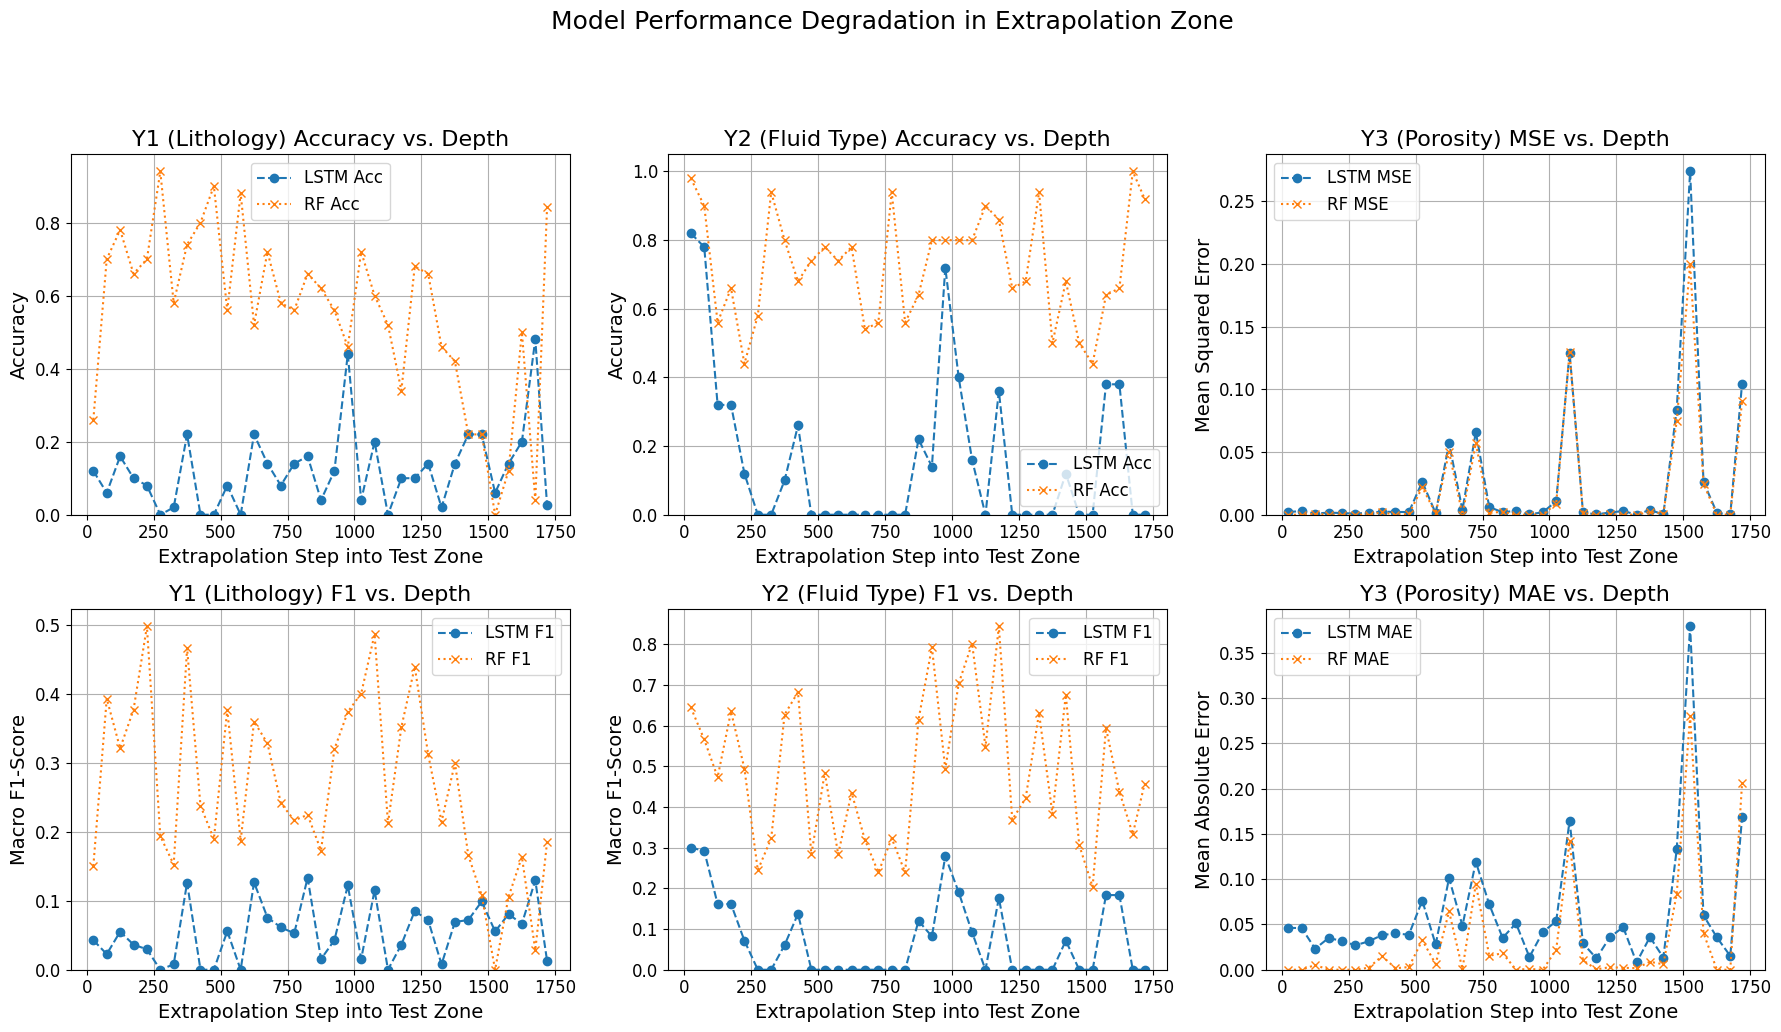

In [27]:
# Cell 20: --- Performance vs. Depth/Step in Extrapolation Zone Plot ---
print("\n=== Analyzing Performance vs. Depth/Step in Extrapolation Zone ===")
can_run_depth_analysis = extrapolation_data_available and all(
    key in predictions_extrap for key in [
        'rf_y1', 'lstm_y1', 'true_y1_seq',
        'rf_y2', 'lstm_y2', 'true_y2_seq',
        'rf_y3', 'lstm_y3', 'true_y3_seq'
    ]
)

if can_run_depth_analysis:
    metrics_vs_depth = {
        'Y1': {'step': [], 'LSTM_Acc': [], 'LSTM_F1': [], 'RF_Acc': [], 'RF_F1': []},
        'Y2': {'step': [], 'LSTM_Acc': [], 'LSTM_F1': [], 'RF_Acc': [], 'RF_F1': []},
        'Y3': {'step': [], 'LSTM_MSE': [], 'LSTM_MAE': [], 'RF_MSE': [], 'RF_MAE': []}
    }
    chunk_size = 50
    # Align RF predictions with LSTM sequence steps
    # LSTM predictions are on X_seq_extrap_yX (length N - window_size)
    # We need RF predictions corresponding to steps window_size to N-1 of original X_extrap
    if len(X_y1_extrap) > window_size: # Check if extrapolation set is large enough
        y1_pred_rf_extrap_seq_aligned = predictions_extrap['rf_y1'][window_size -1 : len(predictions_extrap['true_y1_seq']) + window_size -1] # Aligning based on true_seq length
        y2_pred_rf_extrap_seq_aligned = predictions_extrap['rf_y2'][window_size -1 : len(predictions_extrap['true_y2_seq']) + window_size -1]
        y3_pred_rf_extrap_seq_aligned = predictions_extrap['rf_y3'][window_size -1 : len(predictions_extrap['true_y3_seq']) + window_size -1]

        # Ensure all aligned arrays have the same length as the shortest true sequence
        min_len_y1 = min(len(y1_pred_rf_extrap_seq_aligned), len(predictions_extrap['lstm_y1']), len(predictions_extrap['true_y1_seq']))
        y1_pred_rf_extrap_seq_aligned = y1_pred_rf_extrap_seq_aligned[:min_len_y1]
        y1_pred_lstm_extrap_seq = predictions_extrap['lstm_y1'][:min_len_y1]
        y_seq_extrap_y1_aligned = predictions_extrap['true_y1_seq'][:min_len_y1]
        extrap_steps = min_len_y1

        min_len_y2 = min(len(y2_pred_rf_extrap_seq_aligned), len(predictions_extrap['lstm_y2']), len(predictions_extrap['true_y2_seq']))
        y2_pred_rf_extrap_seq_aligned = y2_pred_rf_extrap_seq_aligned[:min_len_y2]
        y2_pred_lstm_extrap_seq = predictions_extrap['lstm_y2'][:min_len_y2]
        y_seq_extrap_y2_aligned = predictions_extrap['true_y2_seq'][:min_len_y2]


        min_len_y3 = min(len(y3_pred_rf_extrap_seq_aligned), len(predictions_extrap['lstm_y3']), len(predictions_extrap['true_y3_seq']))
        y3_pred_rf_extrap_seq_aligned = y3_pred_rf_extrap_seq_aligned[:min_len_y3]
        y3_pred_lstm_extrap_seq = predictions_extrap['lstm_y3'][:min_len_y3]
        y_seq_extrap_y3_aligned = predictions_extrap['true_y3_seq'][:min_len_y3]


        print(f"Evaluating performance in chunks of {chunk_size} over {extrap_steps} steps...")
        for i in range(0, extrap_steps, chunk_size):
            end_index = min(i + chunk_size, extrap_steps)
            if i == end_index: continue
            step_label = i + (end_index - i) // 2

            # Y1 Chunk
            chunk_true_y1 = y_seq_extrap_y1_aligned[i:end_index]
            chunk_pred_lstm_y1 = y1_pred_lstm_extrap_seq[i:end_index]
            chunk_pred_rf_y1 = y1_pred_rf_extrap_seq_aligned[i:end_index]
            if len(chunk_true_y1) > 0:
                metrics_vs_depth['Y1']['step'].append(step_label)
                metrics_vs_depth['Y1']['LSTM_Acc'].append(accuracy_score(chunk_true_y1, chunk_pred_lstm_y1))
                metrics_vs_depth['Y1']['LSTM_F1'].append(f1_score(chunk_true_y1, chunk_pred_lstm_y1, average='macro', zero_division=0, labels=encoders_ext['y1'].categories_[0]))
                metrics_vs_depth['Y1']['RF_Acc'].append(accuracy_score(chunk_true_y1, chunk_pred_rf_y1))
                metrics_vs_depth['Y1']['RF_F1'].append(f1_score(chunk_true_y1, chunk_pred_rf_y1, average='macro', zero_division=0, labels=encoders_ext['y1'].categories_[0]))

            # Y2 Chunk
            chunk_true_y2 = y_seq_extrap_y2_aligned[i:end_index]
            chunk_pred_lstm_y2 = y2_pred_lstm_extrap_seq[i:end_index]
            chunk_pred_rf_y2 = y2_pred_rf_extrap_seq_aligned[i:end_index]
            if len(chunk_true_y2) > 0:
                metrics_vs_depth['Y2']['step'].append(step_label)
                metrics_vs_depth['Y2']['LSTM_Acc'].append(accuracy_score(chunk_true_y2, chunk_pred_lstm_y2))
                metrics_vs_depth['Y2']['LSTM_F1'].append(f1_score(chunk_true_y2, chunk_pred_lstm_y2, average='macro', zero_division=0, labels=encoders_ext['y2'].categories_[0]))
                metrics_vs_depth['Y2']['RF_Acc'].append(accuracy_score(chunk_true_y2, chunk_pred_rf_y2))
                metrics_vs_depth['Y2']['RF_F1'].append(f1_score(chunk_true_y2, chunk_pred_rf_y2, average='macro', zero_division=0, labels=encoders_ext['y2'].categories_[0]))

            # Y3 Chunk
            chunk_true_y3 = y_seq_extrap_y3_aligned[i:end_index]
            chunk_pred_lstm_y3 = y3_pred_lstm_extrap_seq[i:end_index]
            chunk_pred_rf_y3 = y3_pred_rf_extrap_seq_aligned[i:end_index]
            if len(chunk_true_y3) > 0:
                metrics_vs_depth['Y3']['step'].append(step_label)
                metrics_vs_depth['Y3']['LSTM_MSE'].append(mean_squared_error(chunk_true_y3, chunk_pred_lstm_y3))
                metrics_vs_depth['Y3']['LSTM_MAE'].append(mean_absolute_error(chunk_true_y3, chunk_pred_lstm_y3))
                metrics_vs_depth['Y3']['RF_MSE'].append(mean_squared_error(chunk_true_y3, chunk_pred_rf_y3))
                metrics_vs_depth['Y3']['RF_MAE'].append(mean_absolute_error(chunk_true_y3, chunk_pred_rf_y3))

        # --- Plotting Performance vs. Extrapolation Depth/Step ---
        if not metrics_vs_depth['Y1']['step']:
            print("No metric data to plot for depth analysis.")
        else:
            print("\nPlotting Performance vs. Extrapolation Depth/Step...")
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            fig.suptitle('Model Performance Degradation in Extrapolation Zone', fontsize=TITLE_FONT_SIZE + 2, y=1.03)

            # Y1 Plots
            ax = axes[0, 0]
            ax.plot(metrics_vs_depth['Y1']['step'], metrics_vs_depth['Y1']['LSTM_Acc'], marker='o', linestyle='--', label='LSTM Acc')
            ax.plot(metrics_vs_depth['Y1']['step'], metrics_vs_depth['Y1']['RF_Acc'], marker='x', linestyle=':', label='RF Acc')
            ax.set_title('Y1 (Lithology) Accuracy vs. Depth', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Extrapolation Step into Test Zone', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Accuracy', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE); ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.set_ylim(bottom=0)

            ax = axes[1, 0]
            ax.plot(metrics_vs_depth['Y1']['step'], metrics_vs_depth['Y1']['LSTM_F1'], marker='o', linestyle='--', label='LSTM F1')
            ax.plot(metrics_vs_depth['Y1']['step'], metrics_vs_depth['Y1']['RF_F1'], marker='x', linestyle=':', label='RF F1')
            ax.set_title('Y1 (Lithology) F1 vs. Depth', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Extrapolation Step into Test Zone', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Macro F1-Score', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE); ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.set_ylim(bottom=0)

            # Y2 Plots
            ax = axes[0, 1]
            ax.plot(metrics_vs_depth['Y2']['step'], metrics_vs_depth['Y2']['LSTM_Acc'], marker='o', linestyle='--', label='LSTM Acc')
            ax.plot(metrics_vs_depth['Y2']['step'], metrics_vs_depth['Y2']['RF_Acc'], marker='x', linestyle=':', label='RF Acc')
            ax.set_title('Y2 (Fluid Type) Accuracy vs. Depth', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Extrapolation Step into Test Zone', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Accuracy', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE); ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.set_ylim(bottom=0)

            ax = axes[1, 1]
            ax.plot(metrics_vs_depth['Y2']['step'], metrics_vs_depth['Y2']['LSTM_F1'], marker='o', linestyle='--', label='LSTM F1')
            ax.plot(metrics_vs_depth['Y2']['step'], metrics_vs_depth['Y2']['RF_F1'], marker='x', linestyle=':', label='RF F1')
            ax.set_title('Y2 (Fluid Type) F1 vs. Depth', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Extrapolation Step into Test Zone', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Macro F1-Score', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE); ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.set_ylim(bottom=0)

            # Y3 Plots
            ax = axes[0, 2]
            ax.plot(metrics_vs_depth['Y3']['step'], metrics_vs_depth['Y3']['LSTM_MSE'], marker='o', linestyle='--', label='LSTM MSE')
            ax.plot(metrics_vs_depth['Y3']['step'], metrics_vs_depth['Y3']['RF_MSE'], marker='x', linestyle=':', label='RF MSE')
            ax.set_title('Y3 (Porosity) MSE vs. Depth', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Extrapolation Step into Test Zone', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Mean Squared Error', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE); ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.set_ylim(bottom=0)

            ax = axes[1, 2]
            ax.plot(metrics_vs_depth['Y3']['step'], metrics_vs_depth['Y3']['LSTM_MAE'], marker='o', linestyle='--', label='LSTM MAE')
            ax.plot(metrics_vs_depth['Y3']['step'], metrics_vs_depth['Y3']['RF_MAE'], marker='x', linestyle=':', label='RF MAE')
            ax.set_title('Y3 (Porosity) MAE vs. Depth', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Extrapolation Step into Test Zone', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Mean Absolute Error', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(labelsize=TICK_LABEL_FONT_SIZE); ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.set_ylim(bottom=0)

            plt.tight_layout(rect=[0, 0, 1, 0.97])
            plt.show()
    else:
        print("Skipping performance vs. depth analysis: extrapolation set size <= window size.")
else:
    print("Skipping performance vs. depth analysis: Extrapolation data or predictions not available.")


=== Visualizing Extrapolation Predictions & Plausibility ===
Using actual 'Depth' column for y-axis in log plots (length: 1738).


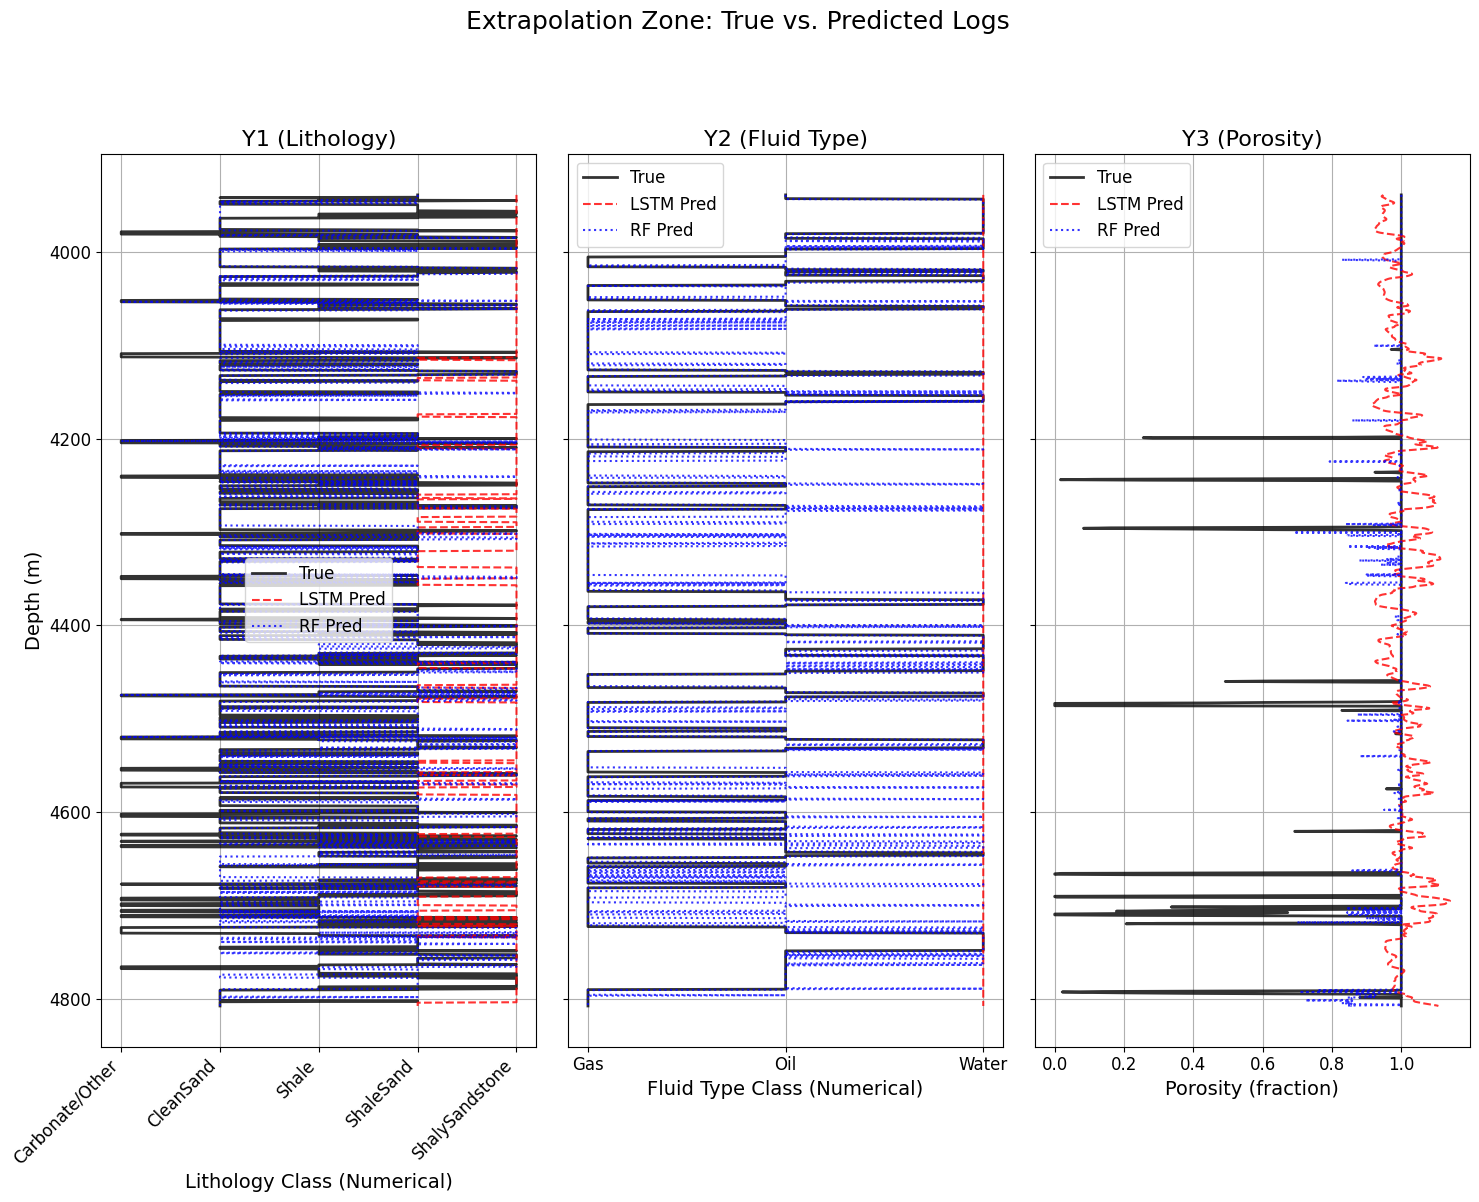


--- Geological Plausibility Checks ---
Examine the plots above:
- Does the LSTM prediction (red dashed line) follow reasonable geological trends?
- Are there any extreme spikes or unrealistic flat lines in the LSTM predictions?
- How does LSTM extrapolation compare visually to RF extrapolation (blue dotted)? Does one look more 'geologically sensible'?

Check value ranges:
LSTM Y3 Extrap Min/Max: 0.915 / 1.141
RF Y3 Extrap Min/Max: 0.690 / 1.000
Unique LSTM Predicted Lithologies: ['ShaleSand' 'ShalySandstone']
Unique LSTM Predicted Fluid Types: ['Water']


In [28]:
# Cell 21: --- Visualization of Extrapolation Results & Plausibility Check ---
print("\n=== Visualizing Extrapolation Predictions & Plausibility ===")

if can_run_depth_analysis and df_extrap is not None: # df_extrap needed for depth axis
    # Use the actual 'Depth' column from the extrapolation part of the dataframe
    # This needs to be aligned with the *sequential predictions* (which start after window_size)
    depth_extrap_axis_raw = df_extrap['Depth'].values
    if len(depth_extrap_axis_raw) > window_size:
        # Align depth axis with the length of the *shortest* true sequential target used in plotting

        if 'true_y1_seq' in predictions_extrap and len(predictions_extrap['true_y1_seq']) > 0:
            plot_len = len(predictions_extrap['true_y1_seq'][:min_len_y1])
            depth_extrap_axis = depth_extrap_axis_raw[window_size-1 : window_size-1 + plot_len]
            depth_label = 'Depth (m)'
            print(f"Using actual 'Depth' column for y-axis in log plots (length: {len(depth_extrap_axis)}).")

            fig, axes = plt.subplots(1, 3, figsize=(15, 12), sharey=True)
            fig.suptitle('Extrapolation Zone: True vs. Predicted Logs', fontsize=TITLE_FONT_SIZE + 2, y=1.0)

            # --- Y1: Lithology Plot (Extrapolation) ---
            ax = axes[0]
            litho_map_ext = {name: i for i, name in enumerate(encoders_ext['y1'].categories_[0])}
            y1_true_num_ext = [litho_map_ext.get(litho, -1) for litho in y_seq_extrap_y1_aligned] # Use aligned true sequence
            # Ensure y1_pred_lstm_extrap_seq and y1_pred_rf_extrap_seq_aligned are used
            y1_lstm_num_ext = [litho_map_ext.get(litho, -1) for litho in y1_pred_lstm_extrap_seq]
            y1_rf_num_ext = [litho_map_ext.get(litho, -1) for litho in y1_pred_rf_extrap_seq_aligned]

            ax.plot(y1_true_num_ext, depth_extrap_axis, label='True', color='black', linewidth=2, alpha=0.8)
            ax.plot(y1_lstm_num_ext, depth_extrap_axis, label='LSTM Pred', color='red', linestyle='--', alpha=0.8)
            ax.plot(y1_rf_num_ext, depth_extrap_axis, label='RF Pred', color='blue', linestyle=':', alpha=0.8)
            ax.set_title('Y1 (Lithology)', fontsize=TITLE_FONT_SIZE)
            ax.set_ylabel(depth_label, fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_xlabel('Lithology Class (Numerical)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_xticks(ticks=range(len(encoders_ext['y1'].categories_[0])))
            ax.set_xticklabels(labels=encoders_ext['y1'].categories_[0], rotation=45, ha='right', fontsize=TICK_LABEL_FONT_SIZE)
            ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.invert_yaxis()
            ax.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)


            # --- Y2: Fluid Type Plot (Extrapolation) ---
            ax = axes[1]
            fluid_map_ext = {name: i for i, name in enumerate(encoders_ext['y2'].categories_[0])}
            y2_true_num_ext = [fluid_map_ext.get(fluid, -1) for fluid in y_seq_extrap_y2_aligned]
            y2_lstm_num_ext = [fluid_map_ext.get(fluid, -1) for fluid in y2_pred_lstm_extrap_seq]
            y2_rf_num_ext = [fluid_map_ext.get(fluid, -1) for fluid in y2_pred_rf_extrap_seq_aligned]

            ax.plot(y2_true_num_ext, depth_extrap_axis, label='True', color='black', linewidth=2, alpha=0.8)
            ax.plot(y2_lstm_num_ext, depth_extrap_axis, label='LSTM Pred', color='red', linestyle='--', alpha=0.8)
            ax.plot(y2_rf_num_ext, depth_extrap_axis, label='RF Pred', color='blue', linestyle=':', alpha=0.8)
            ax.set_title('Y2 (Fluid Type)', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Fluid Type Class (Numerical)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_xticks(ticks=range(len(encoders_ext['y2'].categories_[0])))
            ax.set_xticklabels(labels=encoders_ext['y2'].categories_[0], fontsize=TICK_LABEL_FONT_SIZE)
            ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.invert_yaxis()

            # --- Y3: Porosity Plot (Extrapolation) ---
            ax = axes[2]
            ax.plot(y_seq_extrap_y3_aligned, depth_extrap_axis, label='True', color='black', linewidth=2, alpha=0.8)
            ax.plot(y3_pred_lstm_extrap_seq, depth_extrap_axis, label='LSTM Pred', color='red', linestyle='--', alpha=0.8)
            ax.plot(y3_pred_rf_extrap_seq_aligned, depth_extrap_axis, label='RF Pred', color='blue', linestyle=':', alpha=0.8)
            ax.set_title('Y3 (Porosity)', fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel('Porosity (fraction)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='x', labelsize=TICK_LABEL_FONT_SIZE)
            ax.legend(fontsize=LEGEND_FONT_SIZE); ax.grid(True); ax.invert_yaxis()

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

            # Geological Plausibility Prompts
            print("\n--- Geological Plausibility Checks ---")
            print("Examine the plots above:")
            print("- Does the LSTM prediction (red dashed line) follow reasonable geological trends?")
            print("- Are there any extreme spikes or unrealistic flat lines in the LSTM predictions?")
            print("- How does LSTM extrapolation compare visually to RF extrapolation (blue dotted)? Does one look more 'geologically sensible'?")
            print("\nCheck value ranges:")
            if 'lstm_y3' in predictions_extrap:
                min_lstm_y3_ext, max_lstm_y3_ext = np.nanmin(predictions_extrap['lstm_y3']), np.nanmax(predictions_extrap['lstm_y3'])
                print(f"LSTM Y3 Extrap Min/Max: {min_lstm_y3_ext:.3f} / {max_lstm_y3_ext:.3f}")
            if 'rf_y3' in predictions_extrap:
                min_rf_y3_ext, max_rf_y3_ext = np.nanmin(y3_pred_rf_extrap_seq_aligned), np.nanmax(y3_pred_rf_extrap_seq_aligned)
                print(f"RF Y3 Extrap Min/Max: {min_rf_y3_ext:.3f} / {max_rf_y3_ext:.3f}")
            if 'lstm_y1' in predictions_extrap:
                print(f"Unique LSTM Predicted Lithologies: {np.unique(predictions_extrap['lstm_y1'])}")
            if 'lstm_y2' in predictions_extrap:
                print(f"Unique LSTM Predicted Fluid Types: {np.unique(predictions_extrap['lstm_y2'])}")
        else:
            print("Skipping log visualization: Not enough depth data in extrapolation set for reliable axis, or true sequences missing.")
    else:
        print("Skipping log visualization: Problem with depth axis or extrapolation data.")
else:
    print("Skipping log visualization: Extrapolation data or predictions not available.")